# Data Mining / Prospecção de Dados

## Miguel Casanova, Nº 24475; Pedro Sá, Nº55046, 2019/20


# Project 2 - Clustering

## Logistics

**In a "normal" scenario students should work in teams of 2 people. Due to the social distance imposed by current public health situation, students were allowed to work in groups of 1 and 3. In this context, the amount of work was adapted according to the number of students in groups as described below.**

* Tasks **1 to 5** should be done by **all** groups
* Task **6** should be done only by **groups of 2 and 3** students
* Task **7** should be done only by **groups of 3** students

The quality of the project will then dictate its grade.

**The project's solution should be uploaded in Moodle before the end of May, 17th 2020 (23:59).** 

**It is mandatory to produce a Jupyter notebook containing code and text/images/tables/etc describing the solution and the results. Projects not delivered in this format will not be graded. Note that you can use `PD_201920_Project2.ipynb`as template.**

Students should **upload a `.zip` file** containing all the files necessary for project evaluation. 

**Decisions should be justified and results should be critically discussed.**

## Dataset and Tools

In this project you should use [Python 3](https://www.python.org), [Jupyter Notebook](http://jupyter.org) and **[Scikit-learn](http://scikit-learn.org/stable/)**.

The dataset to be analysed is **`AML_ALL_PATIENTS_GENES_EXTENDED.csv`**. This is an extended version of the widely studied **Leukemia dataset**, originally published by Golub et al. (1999) ["Molecular Classification of Cancer: Class Discovery and Class Prediction by Gene
Expression Monitoring"](http://archive.broadinstitute.org/mpr/publications/projects/Leukemia/Golub_et_al_1999.pdf.) 

**This dataset studies patients with leukaemia. At disease onset clinicials diagnosed them in two different types of leukaemia: acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL).** Some of these diagnoses were later confirmed, other revealed to be wrong. The data analyzed here contains the expression levels of 5147 Human genes (features/columns) analyzed in 110 patients (rows): 70 ALL and 40 AML.
Each row identifies a patient: The first column, `ID`, contains the patients' IDs , the second column, `DIAGNOSIS`, contains the initial diagnosis as performed by clinicians (ground truth), and the remaining 5147 columns contain the expression levels of the 5147 genes analysed.

**The goal is to cluster patients and (ideally) find AML groups and ALL groups.**


<img src="AML_ALL_PATIENTS_GENES_EXTENDED.jpg" alt="AML_ALL_PATIENTS_GENES_EXTENDED.csv" style="width: 1000px;"/>

## 1. Load and Preprocess Dataset

At the end of this step you should have:
* a 110 rows × 5147 columns matrix, **X**, containing the values of the 5147 features for each of the 110 patients.
* a vector, **y**, with the 110 diagnosis, which you can use later to evaluate clustering quality.

In [1]:
import pandas as pd

def load_data(fname):
    """
    Loads and converts a CSV file into different variables, each containing certain information about the dataset.
    Requires: A CSV file (AML_ALL_PATIENTS_GENES_EXTENDED.csv), where each line corresponds to a patient, the 1st column represents
    the patient's ID and the 2nd, the diagnosis for the disease. The remaining columns, represent expression values
    for different microarray probes.
    Ensures: A dataframe of the csv file, a table_x that is a matrix with all expression information for the different patients, 
    a table_y representing a vector where each element is the label for each patient (Diagnosed disease), features_names is
    the header of the CSV file and target, the type of label (DIAGNOSIS, in this case).
    """
    df = pd.read_csv(fname)
    nc = df.shape[1] # number of columns
    matrix = df.values # Convert dataframe to darray
    table_X = matrix [:, 2:nc] # get features ignoring patient ID and diagnosis.
    table_y = matrix [:, 1] # get diagnosis (2nd column)           
    features_names = df.columns.values[2:nc] #get features names (headers of columns)
    target = df.columns.values[1] #get target name
    return df, table_X, table_y, features_names, target
    #return target

## Initial Note
During the course of our analysis, we have came across a problem with the dataset. Several patients have been duplicated (from the 72 original, to 110). One patient has even been triplicated and the label of one of the three triplicated patients has been changed.
Given that these patients were duplicated on top of a normalized and scaled dataset, several changes on the properties of the data were introduced, that could difficult the analysis.
We have thoroughly explored the possibilities and were left with three options:
- 1 - Continue with the provided dataset
- 2 - Eliminate the duplicated (and triplicated) individuals, leaving only the first individual
- 3 - Download, process and analyze the data from Golub et al (https://www.kaggle.com/crawford/gene-expression/kernels)

Given the academic nature of this exercise, and given no specific orientations were provided, we decided to try and carry on our analysis with the provided dataset, without processing it further (beyond the filtering that is asked in the project).

Nevertheless, we provide below all the code required for analysing the data considered in the 3 points above.

## 1.1 - The dataset provided for this work

In [7]:
df, X, y, features_names, target = load_data('AML_ALL_PATIENTS_GENES_EXTENDED.csv')
target

'DIAGNOSIS'

## 1.2 - The dataset where all duplicated (or triplicated) patients were removed

In [ ]:
duplicateRowsDF = df[df.duplicated(['AFFX-BioC-5_at', 'hum_alu_at', 'AFFX-DapX-M_at'], keep=False)]
duplicateRowsDF.sort_values(by=['AFFX-BioC-5_at', 'ID'])

In [ ]:
df1 = df.drop_duplicates(subset=['AFFX-BioC-5_at', 'hum_alu_at', 'AFFX-DapX-M_at'], keep='first')
nc = df1.shape[1] # number of columns
matrix = df1.values # Convert dataframe to darray
X = matrix [:, 2:nc] # get features ignoring patient ID and diagnosis.
y = matrix [:, 1] # get diagnosis (2nd column)           
features_names = df1.columns.values[2:nc] #get features names (headers of columns)
target = df1.columns.values[1] #get target name
df1

## 1.3 - The Golub dataset 
#### (https://www.kaggle.com/crawford/gene-expression/kernels)

In [ ]:
df, X, y, features_names, target = load_data('OriginalGolubDataset.csv')
df.head()

In [ ]:
from sklearn import preprocessing

X = preprocessing.scale(X)
df_scaled = pd.DataFrame(X, columns = features_names)
df_scaled.head()

## 2. Dimensionality Reduction

As you already noticed the number of features (genes) is extremely high when compared to the number of objects to cluster (patients). In this context, you should perform dimensionality reduction, that is, reduce the number of features, in two ways:

* [**Removing features with low variance**](http://scikit-learn.org/stable/modules/feature_selection.html)

* [**Using Principal Component Analysis**](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

At the end of this step you should have two new matrices with the same number of rows, each with a different number of columns (features): **X_variance** and **X_PCA**. 

**Don't change X you will need it!**

### Dimensionality reduction is the process of reducing the dimension of the feature set in a given dataset. It has several advantages, like:
- Reducing space to store data
- Reduces time of computation to handle data
- Some algorithms do not performe well when there are very large dimensions. Reducing these is essential for these to work
- It takes care of multicollinearity by removing redundant features
- It helps in visualizing multidimensional data by reducing the space to 2D or 3D

### 2.1. Removing features with low variance

- Removing features with low variance is a very basic feature selection technique. The principle for using this strategy, lies in the idea that if a feature is constant (in other words, if it has a 0 variance), then it cannot be used for finding any interesting patterns and can be removed from the dataset. Thus, a heuristic approach to feature elimination, is to first remove features whose variance is below a given (low) threshold.
- **This method should be used with caution because a low variance doesn't necessarily mean that a feature is “uninteresting”.**
- **In fact, we would not even think about this option for dimensionality reduction of our dataset, as we believe this is changing the dataset, by removing information that might be relevant.**

In [3]:
# Let's start by loading a few modules we will use for running this notebook! We will run plenty more, as we go along!
%matplotlib inline  
import matplotlib
import numpy as np
import sys
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt

#### 2.1.1. Calculating the variance for each gene (feature) considering all patients in the dataset.
- We use the VarianceThreshold function, to calculate the variance for each of the microarray probe, for 110 patients.

In [4]:
from sklearn.feature_selection import VarianceThreshold
np.set_printoptions(threshold=sys.maxsize)

Var_thresh = VarianceThreshold()
scaled = Var_thresh.fit(X)
vari = scaled.variances_

column_vari = []
vari_index = 0
columns_index = 0
while columns_index < len(features_names):
    feature = features_names[columns_index]
    variance = vari[vari_index]
    column_vari.append([feature, variance])
    vari_index += 1
    columns_index += 1
    
column_vari = pd.DataFrame(column_vari, columns = ['ProbeID', 'Variance'])
column_vari.sort_values(by=['Variance'], ascending=False)

,ProbeID,Variance
4913,Z46632_r_at,1.301117
2184,U28368_at,1.289791
739,HG4263-HT4533_at,1.288485
2195,U29195_at,1.286844
2221,U31384_at,1.286748
...,...,...
566,D87444_at,0.664382
5118,X71345_f_at,0.662575
5098,M22612_f_at,0.661980
4050,X02419_rna1_s_at,0.661555


- **The choice of a variance threshold is a subjective decision. So, to make a more informed guess, we will calculate the mean variance for all of the features in the dataset and select only those which variance is above that.**

In [5]:
# Calculate the mean of the variances determined above for each gene.
featVar = round(column_vari['Variance'].mean(), 3)
print("The mean variance of all the features is", featVar)

The mean variance of all the features is 0.976


#### 2.1.2. Determining genes with greater variances 
- Using the above information, we will create a new matrix for our dataset, excluding the features that show a variance lower than the mean average of all the features.

In [6]:
# To facilitate the identification of the features kept, we will create a DataFrame with the labels for all the features in the dataset.
X_labels = pd.DataFrame(X, columns = features_names)

In [7]:
def variance_threshold_selector(dataset, threshold):
    '''
    This function takes a dataset and transforms it, by eliminating columns with a variance lower than the threshold.
    Requires: A dataframe or matrix and a value for minimum threshold of variance.
    Ensures: A new dataframe or matrix, filtered to eliminate all the columns with a variance below the threshold provided.
    '''
    selector = VarianceThreshold(threshold)
    selector.fit(dataset)
    scaled = dataset[dataset.columns[selector.get_support(indices=True)]]
    return scaled

In [8]:
# We next create the dataframe with the selected features, filtered by the variance threshold we defined.
X_variance = variance_threshold_selector(X_labels, threshold = featVar)
X_variance

,AFFX-BioC-5_at,AFFX-DapX-M_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMGAPDH/M33197_5_at,AFFX-HUMGAPDH/M33197_M_at,AFFX-HUMGAPDH/M33197_3_at,AFFX-HUMTFRR/M11507_5_at,AFFX-HUMTFRR/M11507_M_at,...,V00533_rna1_f_at,V01516_f_at,X64177_f_at,Z80780_f_at,HG658-HT658_f_at,X03068_f_at,L10717_at,X06956_at,X83863_at,M71243_f_at
0,-0.912181,1.33068,0.236442,0.196788,0.244435,-0.0296446,-0.528565,-0.203529,-0.205611,-0.0257334,...,1.11203,0.00016935,-0.475775,0.316963,0.797845,0.00626544,0.343097,0.0191404,0.0277713,-0.391378
1,0.842926,-0.067011,-0.224387,-0.200579,-0.3716,0.698765,0.0353917,-0.122523,0.906362,0.370614,...,-0.171473,0.183067,0.473281,0.243455,0.600991,-0.464957,2.47267,0.160143,0.00322345,-0.57699
2,1.07694,1.85975,0.498175,1.24439,1.39019,2.0253,0.77163,1.07883,1.33507,-0.0448345,...,-1.12493,-0.377819,-0.138825,0.558691,-1.17469,-0.653051,0.725328,-0.568816,0.79768,-0.331659
3,-1.59622,0.991127,-0.0655575,-0.0440404,-0.402063,-0.0556355,-0.456281,-0.240105,-0.567337,-0.617867,...,0.415271,0.280613,0.0220715,-0.187696,-0.577893,-0.409356,-0.596098,-0.552853,-0.342677,-0.496289
4,-0.192137,-0.193356,0.142487,-0.176496,-0.28698,-0.10012,0.373027,-0.301228,-0.0850354,0.0124688,...,0.207466,-0.993575,0.348528,0.0582722,-0.705474,-0.490194,-0.355838,0.32509,-1.184,-0.609271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,1.82399,0.667369,0.72859,0.37741,0.11412,1.05597,0.37372,0.713565,5.7919,5.02173,...,-1.35719,1.40848,-0.373175,0.338167,0.00718823,-0.760308,-0.617939,-0.137825,1.75504,3.36768
106,1.15795,-1.2357,0.748723,0.244954,0.117504,1.87635,0.971394,1.29632,-0.183282,0.0506709,...,-1.01492,0.225743,0.552564,-0.00675392,1.32536,1.13602,-0.869119,0.277203,1.14358,-0.302607
107,-0.795174,0.233058,0.117879,0.0643325,-0.464682,0.401537,0.103057,0.208868,0.142718,-0.331351,...,-0.305936,2.15836,-0.103848,0.13178,-0.790446,-0.370318,0.0591547,-0.645969,0.119268,-0.158959
108,-1.59622,0.991127,-0.0655575,-0.0440404,-0.402063,-0.0556355,-0.456281,-0.240105,-0.567337,-0.617867,...,0.415271,0.280613,0.0220715,-0.187696,-0.577893,-0.409356,-0.596098,-0.552853,-0.342677,-0.496289


### 2.2. Using Principal Component Analysis

- One of the main linear techniques for dimensionality reduction is principal component analysis (PCA). PCA works by performing a linear mapping of the data to a lower-dimensional space in such a way that the variance of the data in the low-dimensional representation is maximized. More precisely, a covariance (ans sometimes the correlation) matrix of the data is constructed and the eigenvectors of the matrix are determined. The eigenvectors that correspond to the largest eigenvalues (the principal components) are then used to reconstruct a large fraction of the variance of the orginal dataset. What's interesting is that, normally, the first few eigenvectors contribute to the majority of the variance of the data. Let's see if this is the case for our dataset.

#### In order to perform dimensionality reduction, we will first try to determine how many components are required to describe a reasonable percentage of the variance in the data.

In [9]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)
expl_var = pca.explained_variance_/sum(pca.explained_variance_)
print("Ratio of explained variance")
for i in range(5):
    print("PC%d -> %7.4f" % (i, expl_var[i]))    

Ratio of explained variance
PC0 ->  0.1477
PC1 ->  0.1186
PC2 ->  0.0531
PC3 ->  0.0440
PC4 ->  0.0341


#### As we can see, the first 5 components describe only a very small percentage of the variance in the dataset (~37%). Thus, we will calculate the minimum number of components to achieve an acceptable variance for our further analysis (let's settle on 70%).
- Let's visualize how much variance each individual component explains.

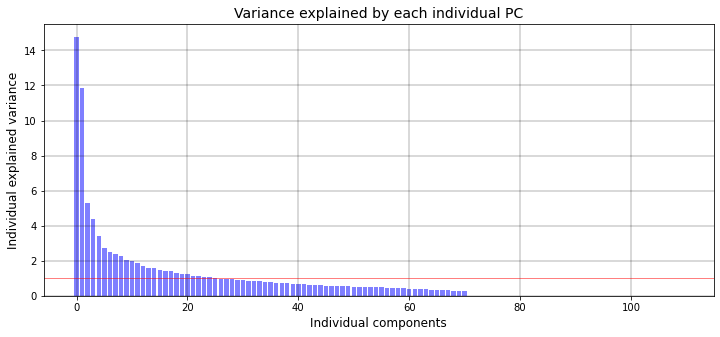

In [10]:
pca = PCA()
pca.fit(X)
X_pca = pca.transform(X)
var_exp = pca.explained_variance_ratio_
var_exp = var_exp*100

fig, ax = plt.subplots(figsize=(12,5))
plt.bar(range(len(X_pca)), var_exp, label='Explained Variance per PC', color = 'blue', alpha = 0.5)
plt.title("Variance explained by each individual PC", fontsize=14)
plt.xlabel('Individual components', fontsize = 12)
plt.ylabel('Individual explained variance', fontsize = 12)
plt.axhline(y=1, color='r', lw = 0.5) # Let's add a line to represent the components explaining less than 1% of variance.
plt.grid(lw=0.3, color='k')
plt.show()

#### Note: Here we can see an unusual behaviour in our data - after PC72, every other PC has no ability to explain the variance of the data. This was the first hint, suggesting that some patients had been duplicated in the dataset.

#### How many PCs do we need to explain 70% of the variance in the dataset?

In [11]:
# Let's make a simple iteration over the ratio of explained variances per component and calculate this.
var = 0
PC_count = 0
for i in expl_var:
    if var < 0.70:
        var += i
        PC_count += 1
        
print("To achieve an explanation of " + str(round(100*var, 2)) + "% of variance in the dataset, we need to consider the first", PC_count, "components.")

To achieve an explanation of 70.75% of variance in the dataset, we need to consider the first 23 components.


### The first 23 components, explain 70% of the variance, which is a quite nice value. 
#### Let's visualize the cumulative data variance explained by an increasing number of principal components.

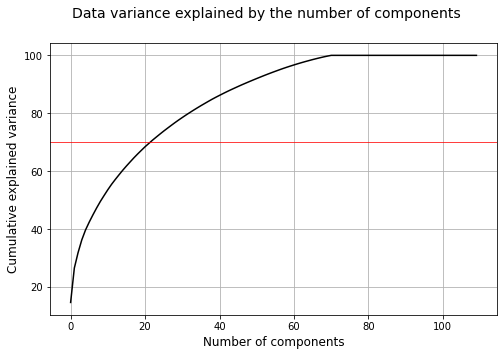

In [12]:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100, 'black')
plt.suptitle('Data variance explained by the number of components', fontsize = 14)
plt.xlabel('Number of components', fontsize = 12)
plt.ylabel('Cumulative explained variance', fontsize = 12)
plt.axhline(y=70, color='r', lw=0.75) # Let's add a line representing our targeted cumulative variance of 70%
plt.grid()
plt.show()

- Note: Here, it became obvious that the dataset had a problem. As we can see, after 72 components, no more variance can be explained. This is indeed due to the fact that the dataset had only 72 original patients. The remaining patients are duplications of some of these 72 original patients. One patient has even been triplicated and assigned a wrong label, which we will visualize later on.
- Limiting the number of components will help us deal with this issue.

#### As we can't visualize all the dimensions of the data in a graph, we are going to select the 3 first components (the ones that explain more variation) and plot these in a 3D graph.
- We will label the individuals by diagnosis (blue for ALL and red for AML)

<Figure size 432x288 with 0 Axes>

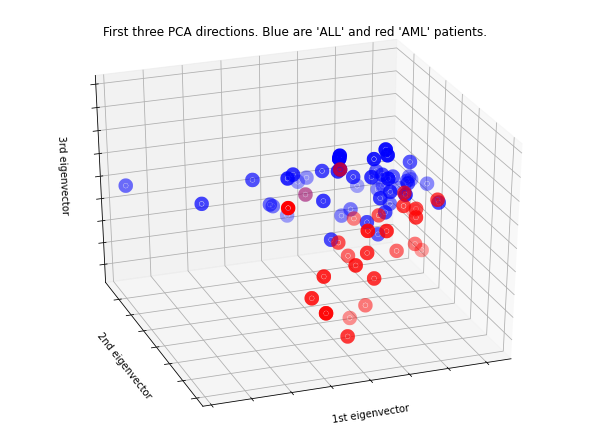

In [13]:
from sklearn.decomposition import PCA as PCA
from mpl_toolkits.mplot3d import Axes3D

pca3 = PCA(n_components=3).fit(X)
X_reduced = pca3.fit_transform(X)

Y = []
for i in y:
    if i == 'ALL':
        Y.append('b')
    else:
        Y.append('r')

plt.clf()
fig = plt.figure(figsize = (8,6))
ax = Axes3D(fig, elev = -150, azim = 110,)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c = Y, cmap = plt.cm.Paired, linewidths = 10)
ax.set_title("First three PCA directions. Blue are 'ALL' and red 'AML' patients.")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])
plt.show()

#### Let's have a look at this data in a 2D graph (with just the 2 first components)

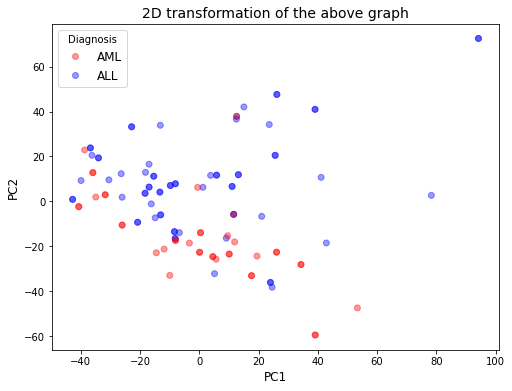

In [15]:
from matplotlib.colors import ListedColormap

X_pca = pca.transform(X)

ytransf = []
for i in y:
    if i == 'ALL':
        ytransf.append(1)
    else:
        ytransf.append(0)
        
values = ytransf
classes = set(y)
colours = ListedColormap(["r", "b"])

fig = plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.4, c=values, cmap=colours)
leg = plt.legend(handles=scatter.legend_elements()[0], labels=classes, title='Diagnosis', fontsize=12)
plt.title("2D transformation of the above graph", fontsize=14)
plt.xlabel('PC1', fontsize = 12)
plt.ylabel('PC2', fontsize = 12)
plt.show()

- We can see that there isn't, for these first components, a very strong clustering of the data.

## A point about scaling data. 
- There doesn't seem to be a scaling problem with our data. It seems this data was previously normalized and scaled, so that the values are all approximate and comparable. Nevertheless, we will scale the data and compare it to the unscalled data, to check whether this improves the results.
- If the values would need scaling, the explained variance per principal component would likely change dramatically between unscalled and scalled data. Let's quickly check whether this is the case for the scalled data.

#### Note: During the course of our analysis, we figured out that the data has been tampered and a significant proportion of 72 original patients was duplicated and added into the final dataset. This changes the individual variance of the features and might introduce bias in the data. As we realized this very late, our analysis didn't deal with this point.

In [20]:
from sklearn import preprocessing

X_scaled = preprocessing.scale(X)
df_scaled = pd.DataFrame(X_scaled, columns = features_names)
df_scaled.head()

,AFFX-BioC-5_at,hum_alu_at,AFFX-DapX-M_at,AFFX-LysX-5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,AFFX-HUMRGE/M10098_3_at,...,M93143_at,U29175_at,U48730_at,U58516_at,X06956_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,-0.878400,-0.911964,1.359172,0.134918,0.233669,0.178298,0.211658,2.872903,2.781683,2.143967,...,0.486708,1.082952,0.108604,-0.557013,0.016958,0.052408,0.158974,0.615572,-0.372261,-0.168980
1,0.879711,-1.304721,-0.047915,-0.902223,-0.215778,-0.203769,-0.360770,-0.389321,-0.384022,0.065671,...,-0.428827,-0.456837,-0.073437,0.552927,0.154462,0.027838,-0.021306,0.026764,-0.559681,0.432312
2,1.114126,-0.756819,1.891799,1.270834,0.488938,1.185566,1.276311,0.794855,0.654545,0.703003,...,2.497295,-0.249496,1.587688,1.785438,-0.556407,0.822989,2.534429,0.733334,-0.311961,-0.273552
3,-1.563612,-0.846844,1.017338,0.678182,-0.060872,-0.053258,-0.389077,0.602960,0.332481,0.377223,...,0.025948,-0.265569,0.734370,0.546118,-0.540841,-0.318365,-0.684100,-1.409928,-0.478194,-1.580707
4,-0.157123,-0.617663,-0.175109,-0.581203,0.142034,-0.180614,-0.282140,-0.232571,0.476571,-0.290642,...,-0.745973,-0.453623,-0.221345,-0.087161,0.315316,-1.160420,0.079439,0.097421,-0.592275,0.144738


In [21]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_scaled)
expl_var = pca.explained_variance_/sum(pca.explained_variance_)
print("Ratio of explained variance")
for i in range(5):
    print("PC%d -> %7.4f" % (i, expl_var[i]))

Ratio of explained variance
PC0 ->  0.1474
PC1 ->  0.1171
PC2 ->  0.0526
PC3 ->  0.0433
PC4 ->  0.0342


In [22]:
# How many PCs do we need to explain 70% of the variance in the dataset?
# Let's make a simple iteration over the ratio of explained variances per component and calculate this.
var = 0
PC_count = 0
for i in expl_var:
    if var < 0.70:
        var += i
        PC_count += 1

print("To achieve an explanation of " + str(round(100*var, 2)) + "% of variance in the dataset, we need to consider the first", PC_count, "components.")

To achieve an explanation of 70.38% of variance in the dataset, we need to consider the first 23 components.


#### As we can see, there is absolutely no change in the number of components required to calculate 70% of the data variance! Thus, we confirm that there is no need to scale this dataset.
#### With this information in hand, we can transform our data, by using PCA for demensionality reduction. We will use a number of PCs that explain an important portion of the data variance in the dataset. In this case, we will transform our multidimensional data to only 23 dimensions, which explains 70% of the overall variance.

In [23]:
pca = PCA(n_components=23)
pca.fit(X)
X_PCA = pca.transform(X)

labels_PCA = []
for i in range(23):
    labels_PCA.append("PC%d" % (i+1))

pd.DataFrame(X_PCA, columns = labels_PCA)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23
0,21.059835,-6.666308,-21.153680,-1.425976,0.493175,-5.443212,5.807316,-9.765593,1.581061,-0.215585,...,2.330195,6.818906,-5.449854,2.802468,2.143236,-0.333974,-6.203137,0.885363,-0.964509,1.885187
1,11.068415,6.656194,14.182931,-12.799719,16.529336,2.770522,17.392088,19.212867,2.995673,15.970575,...,-3.021712,1.010059,2.739683,1.786488,8.269925,-4.572650,-1.097416,-12.385381,-6.375982,16.122134
2,42.868979,-18.536302,-24.157036,-9.293413,30.860011,-7.943449,22.597366,10.679628,-1.081873,-11.301230,...,-5.088221,-9.318484,-1.854739,-0.208442,-6.491689,1.118881,4.258886,2.704381,5.075353,2.413007
3,11.592286,-5.785323,-20.455331,3.933000,21.828275,-1.242259,-22.476553,-18.742215,5.658179,1.069032,...,-3.725975,-1.250396,-5.311681,6.677508,20.221499,3.127455,0.815987,7.060544,-12.637036,-3.206362
4,12.581586,37.884907,4.246703,6.042957,11.365012,0.027437,-4.914496,-10.477381,-10.872613,-9.639821,...,-3.370880,-2.348136,-6.159788,-12.814069,0.964069,0.078577,-4.572896,-0.734313,-4.483190,2.740472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,10.092145,-23.483589,15.352896,-37.484931,-8.588668,16.939226,-17.633736,10.777121,-8.447818,-12.045323,...,4.651817,-15.190436,-22.862326,-8.523398,10.738616,-3.999662,-8.902753,5.875530,3.366021,-0.169451
106,17.629313,-33.112170,42.606899,14.374282,0.620489,-28.418057,18.685225,-21.015808,0.430660,-7.514268,...,19.054553,-9.149031,23.776438,-13.776812,19.232077,4.504233,8.938388,5.046974,-6.336343,-5.172727
107,4.573231,-24.622948,0.539875,7.976825,0.077028,15.367986,5.747641,-0.529076,-5.003489,5.030687,...,2.926604,10.289084,-0.951129,-15.420937,-4.915202,3.461816,-5.572130,-4.334326,-9.074562,-0.303087
108,11.592286,-5.785323,-20.455331,3.933000,21.828275,-1.242259,-22.476553,-18.742215,5.658179,1.069032,...,-3.725975,-1.250396,-5.311681,6.677508,20.221499,3.127455,0.815987,7.060544,-12.637036,-3.206362


## Summing up, we have created three datasets:

- The full dataset - **X**

In [24]:
pd.DataFrame(X, columns = features_names)

,AFFX-BioC-5_at,hum_alu_at,AFFX-DapX-M_at,AFFX-LysX-5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,AFFX-HUMRGE/M10098_3_at,...,M93143_at,U29175_at,U48730_at,U58516_at,X06956_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,-0.912181,-0.93628,1.33068,0.045416,0.236442,0.196788,0.244435,2.56173,2.48996,1.79452,...,0.42894,1.01868,0.103263,-0.518375,0.0191404,0.0277713,0.122186,0.593119,-0.391378,-0.161117
1,0.842926,-1.31132,-0.067011,-0.964423,-0.224387,-0.200579,-0.3716,-0.417306,-0.408754,-0.00293052,...,-0.425219,-0.474402,-0.0679007,0.555431,0.160143,0.00322345,-0.0436184,0.0321026,-0.57699,0.415146
2,1.07694,-0.788133,1.85975,1.15143,0.498175,1.24439,1.39019,0.664072,0.542223,0.548277,...,2.30474,-0.27335,1.49396,1.74782,-0.568816,0.79768,2.3069,0.705322,-0.331659,-0.261337
3,-1.59622,-0.874097,0.991127,0.574379,-0.0655575,-0.0440404,-0.402063,0.488835,0.247321,0.26652,...,-0.000930456,-0.288936,0.691636,0.548844,-0.552853,-0.342677,-0.653193,-1.33678,-0.496289,-1.51408
4,-0.192137,-0.655253,-0.193356,-0.651854,0.142487,-0.176496,-0.28698,-0.274163,0.379259,-0.311094,...,-0.721104,-0.471285,-0.206971,-0.063819,0.32509,-1.184,0.0490369,0.0994245,-0.609271,0.139542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,1.82399,-0.536994,0.667369,-0.772073,0.72859,0.37741,0.11412,-0.373657,-0.288865,0.104747,...,-0.821593,-1.00119,-0.773949,1.49089,-0.137825,1.75504,1.57541,0.256509,3.36768,0.765915
106,1.15795,-0.124383,-1.2357,-0.291197,0.748723,0.244954,0.117504,-0.424794,-0.404235,-0.401851,...,0.696912,-0.804812,0.62745,3.24324,0.277203,1.14358,0.185582,0.368712,-0.302607,1.34218
107,-0.795174,-0.785912,0.233058,-0.0267153,0.117879,0.0643325,-0.464682,-0.441056,-0.415682,-0.362882,...,1.05421,-0.739353,0.90559,1.12198,-0.645969,0.119268,1.23405,-0.484032,-0.158959,-0.862654
108,-1.59622,-0.874097,0.991127,0.574379,-0.0655575,-0.0440404,-0.402063,0.488835,0.247321,0.26652,...,-0.000930456,-0.288936,0.691636,0.548844,-0.552853,-0.342677,-0.653193,-1.33678,-0.496289,-1.51408


- A dataset where we removed features with low variance (2512 features out of 5147) - **X_variance**

In [25]:
pd.DataFrame(X_variance)

,AFFX-BioC-5_at,AFFX-DapX-M_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMGAPDH/M33197_5_at,AFFX-HUMGAPDH/M33197_M_at,AFFX-HUMGAPDH/M33197_3_at,AFFX-HUMTFRR/M11507_5_at,AFFX-HUMTFRR/M11507_M_at,...,V00533_rna1_f_at,V01516_f_at,X64177_f_at,Z80780_f_at,HG658-HT658_f_at,X03068_f_at,L10717_at,X06956_at,X83863_at,M71243_f_at
0,-0.912181,1.33068,0.236442,0.196788,0.244435,-0.0296446,-0.528565,-0.203529,-0.205611,-0.0257334,...,1.11203,0.00016935,-0.475775,0.316963,0.797845,0.00626544,0.343097,0.0191404,0.0277713,-0.391378
1,0.842926,-0.067011,-0.224387,-0.200579,-0.3716,0.698765,0.0353917,-0.122523,0.906362,0.370614,...,-0.171473,0.183067,0.473281,0.243455,0.600991,-0.464957,2.47267,0.160143,0.00322345,-0.57699
2,1.07694,1.85975,0.498175,1.24439,1.39019,2.0253,0.77163,1.07883,1.33507,-0.0448345,...,-1.12493,-0.377819,-0.138825,0.558691,-1.17469,-0.653051,0.725328,-0.568816,0.79768,-0.331659
3,-1.59622,0.991127,-0.0655575,-0.0440404,-0.402063,-0.0556355,-0.456281,-0.240105,-0.567337,-0.617867,...,0.415271,0.280613,0.0220715,-0.187696,-0.577893,-0.409356,-0.596098,-0.552853,-0.342677,-0.496289
4,-0.192137,-0.193356,0.142487,-0.176496,-0.28698,-0.10012,0.373027,-0.301228,-0.0850354,0.0124688,...,0.207466,-0.993575,0.348528,0.0582722,-0.705474,-0.490194,-0.355838,0.32509,-1.184,-0.609271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,1.82399,0.667369,0.72859,0.37741,0.11412,1.05597,0.37372,0.713565,5.7919,5.02173,...,-1.35719,1.40848,-0.373175,0.338167,0.00718823,-0.760308,-0.617939,-0.137825,1.75504,3.36768
106,1.15795,-1.2357,0.748723,0.244954,0.117504,1.87635,0.971394,1.29632,-0.183282,0.0506709,...,-1.01492,0.225743,0.552564,-0.00675392,1.32536,1.13602,-0.869119,0.277203,1.14358,-0.302607
107,-0.795174,0.233058,0.117879,0.0643325,-0.464682,0.401537,0.103057,0.208868,0.142718,-0.331351,...,-0.305936,2.15836,-0.103848,0.13178,-0.790446,-0.370318,0.0591547,-0.645969,0.119268,-0.158959
108,-1.59622,0.991127,-0.0655575,-0.0440404,-0.402063,-0.0556355,-0.456281,-0.240105,-0.567337,-0.617867,...,0.415271,0.280613,0.0220715,-0.187696,-0.577893,-0.409356,-0.596098,-0.552853,-0.342677,-0.496289


- A dataset where we used PCA to reduce the dimensionality of our dataset, to consider only the first 23 components that explain 70% of the variance in the data - **X_PCA**

In [26]:
pd.DataFrame(X_PCA, columns = labels_PCA)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23
0,21.059835,-6.666308,-21.153680,-1.425976,0.493175,-5.443212,5.807316,-9.765593,1.581061,-0.215585,...,2.330195,6.818906,-5.449854,2.802468,2.143236,-0.333974,-6.203137,0.885363,-0.964509,1.885187
1,11.068415,6.656194,14.182931,-12.799719,16.529336,2.770522,17.392088,19.212867,2.995673,15.970575,...,-3.021712,1.010059,2.739683,1.786488,8.269925,-4.572650,-1.097416,-12.385381,-6.375982,16.122134
2,42.868979,-18.536302,-24.157036,-9.293413,30.860011,-7.943449,22.597366,10.679628,-1.081873,-11.301230,...,-5.088221,-9.318484,-1.854739,-0.208442,-6.491689,1.118881,4.258886,2.704381,5.075353,2.413007
3,11.592286,-5.785323,-20.455331,3.933000,21.828275,-1.242259,-22.476553,-18.742215,5.658179,1.069032,...,-3.725975,-1.250396,-5.311681,6.677508,20.221499,3.127455,0.815987,7.060544,-12.637036,-3.206362
4,12.581586,37.884907,4.246703,6.042957,11.365012,0.027437,-4.914496,-10.477381,-10.872613,-9.639821,...,-3.370880,-2.348136,-6.159788,-12.814069,0.964069,0.078577,-4.572896,-0.734313,-4.483190,2.740472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,10.092145,-23.483589,15.352896,-37.484931,-8.588668,16.939226,-17.633736,10.777121,-8.447818,-12.045323,...,4.651817,-15.190436,-22.862326,-8.523398,10.738616,-3.999662,-8.902753,5.875530,3.366021,-0.169451
106,17.629313,-33.112170,42.606899,14.374282,0.620489,-28.418057,18.685225,-21.015808,0.430660,-7.514268,...,19.054553,-9.149031,23.776438,-13.776812,19.232077,4.504233,8.938388,5.046974,-6.336343,-5.172727
107,4.573231,-24.622948,0.539875,7.976825,0.077028,15.367986,5.747641,-0.529076,-5.003489,5.030687,...,2.926604,10.289084,-0.951129,-15.420937,-4.915202,3.461816,-5.572130,-4.334326,-9.074562,-0.303087
108,11.592286,-5.785323,-20.455331,3.933000,21.828275,-1.242259,-22.476553,-18.742215,5.658179,1.069032,...,-3.725975,-1.250396,-5.311681,6.677508,20.221499,3.127455,0.815987,7.060544,-12.637036,-3.206362


## 3. Clustering Patients using Partitional Clustering

Use **`K`-means** to cluster the patients:

* Cluster the original data (5147 features): **X**.
    * Use different values of `K`.
    * For each value of `K` present the clustering by specifying how many patients ALL and AML are in each cluster.     
    For instance, `{0: {'ALL': 70, 'AML': 0}, 1: {'ALL': 0, 'AML': 40}}` is the ideal clustering that we aimed at obtained with K-means when `K=2`, where the first cluster has 70 ALL patients and 0 AML patients and the second cluster has 0 ALL patients and 40 AML patients. 
    You can choose how to output this information.  
    * What is the best value of `K` ? Justify using the clustering results and the [Silhouette score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).

* Cluster the data obtained after removing features with low variance: **X_variance**.
    * Study different values of `K` as above.

* Cluster the data obtained after applying PCA: **X_PCA**.
    * Study different values of `K` as above.

* Compare the results obtained in the three datasets above for the best `K`. Discuss.

## A few brief considerations about clustering

Clustering is used to find patterns in data. In the present case, clustering this dataset would allow us to identify individuals whose gene expression show similar patterns. Clustering is thus an exploratory approach that tries to find objets that are similar to each other, and separated from other objects.
Clustering has a few limitations that have to be kept in mind:
- It is an exploratory technique, usually with no significance available.
- Different approaches can lead to different groupings
- It is difficult to decide which is the best (or in this case, biologically "real") clustering
- It is very hard, when provided with a label, to avoid the temptation of selecting the grouping that best fits the labels

## A few considerations about the Golub dataset

We should mention here, that the study of Golub et al, was published in 1999, using outdated techniques for both measuring gene expression (microarray technology), but also for expression analysis. So, all the interpretation within this work, will keep this in mind.<br> 
Moreover, a brief introduction to leukemia has to be made, to put all our interpretation into a biological perspective. Leukemia is a type of blood cancers that usually begins in the bone marrow and results in high numbers of abnormal blood cells. These blood cells are not fully differentiated and are called blasts. Due to the nature of the cancer disease and the mutations leading to the appearance and development of leukemia, a heterogenous group and number of cells arise that, albeit sharing some similarities, are also genetically and molecularly different. In fact, there are, to date, four main types of leukemia identified: acute lymphoblastic leukemia (ALL), acute myeloid leukemia (AML), chronic lymphocytic leukemia (CLL) and chronic meyleoid leukemia (CML). But, to make matters even more complicated, many other less common types (and subtypes) of leukemia exist, raising some doubts on the original diagnosis and clustering obtained.

### 3.1 Clustering with K-means
The K-Means algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. This algorithm requires the number of clusters to be specified. It scales well to large number of samples and has been used across a large range of application areas in many different fields.

Briefly, here's the run through of how the algorithm works:
- 1. Initialise Centroids: Create a random set of  𝐾  centroids
- 2. Compute distance to centroids and assign points to clusters: Verify which data points are closer to each centroid and assign each point to the closest centroid
- 3. Recompute the centroids: Move the centroids to a new position according to the assignments made
- 4. Repeat steps 2 and 3 until a criterium is met: no more points change cluster or maximum iterations reached.  


We will start by defining a few functions that we can use to automate our analysis.

In [28]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn.metrics.cluster import silhouette_score, silhouette_samples

def clusteringKmeans (dataset, k):
    """
    This functions runs the k-means algorith from scikit learn. 
    It clusters the data in k clusters.
    Requires: A data matrix in which each line is an element of the dataset. A k value that is an int (number of clusters).
    Ensures: Provides a vector with the clusters to which each element were attributed.
    """
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans = kmeans.fit(dataset)
    kmeans.cluster_centers_
    l = kmeans.labels_
    return l

def getLabelsClustering(c, l, labels):
    """
    This function will generate a dictionary as the one exemplified in this notebook. 
    The dictionary will have the clusters produced (as dictionary keys), plus a count dictionary
    for the number of entities clustered to each of the labels in the dataset.
    Requires: c is the number of clusters (int > 0), l is a vector the clusters to which each element are attributed and labels is 
    a vector with the label for each entity.
    Ensures: Dictionary to count the number of entities clustered to the different clusters (and their labels).
    """

    dic = {}

    for i in range(c):
        dic[i] = {}

    for i in range(len(l)):
        for v in dic:
            if l[i] == v:
                if labels[i] in dic[v]:
                    dic[v][labels[i]] += 1
                else:
                    dic[v][labels[i]] = 1         
    return dic

def drawSillouette(X, labels, header=""):
    """
    This function was provided by André Falcão, in the TP classes of TPD. It takes a dataset, a set of clustering labels
    and a string as a header, to plot a silhouette profile of the clustering obtained.
    Requires: X is a dataset, labels are the clustering labels obtained for the dataset, using different clustering algorithms
    and header is a string of text, that will be used as the title of the plot.
    """
    y_lower =10
    clusters=list(set(labels))
    n_clusters=len(clusters)

    fig = plt.figure(figsize=(5,4))
    ax1 = plt.gca()
    ax1.set_xlim([-0.5, 1])
    ax1.set_ylim([0, len(X) + (n_clusters) * 3+ y_lower])
    sil_avg = silhouette_score(X, labels)
    for i,c in enumerate(clusters):
        silhouette_values = silhouette_samples(X, labels)
        cs_values = silhouette_values[labels == c]
        cs_values.sort()
        size_ci = cs_values.shape[0]
        y_upper = y_lower + size_ci
        color = cm.nipy_spectral(i / n_clusters) #np.array(["r", "g", "b", "k", "y"])[i] #
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cs_values, facecolor=color, edgecolor="k", alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_ci, str(c))
        y_lower = y_upper + 3  # 10 for the 0 samples
    ax1.set_title("Silhouette plot "+ header)
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Clusters")
    ax1.axvline(x=sil_avg, c="r", linestyle="--")

    ax1.set_yticks([]) 
    plt.show()

- Determining the appropriate number of clusters is one of the trickier tasks when clustering. 
- In cluster analysis, the elbow method is a heuristic used in determining the number of clusters in a data set. It consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.
- In other words, if the line of the chart resembles an arm, then the "elbow" (the inflection point on the curve) can be a good indication that the underlying model fits best at that point.
- Let's see if that's the case for this dataset!

In [29]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

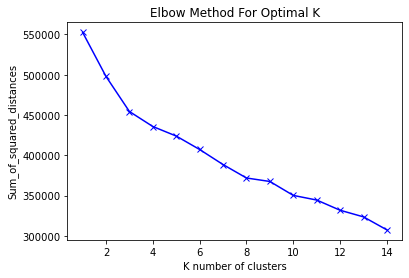

In [30]:
plt.figure(figsize=(6,4))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('K number of clusters', fontsize=10)
plt.ylabel('Sum_of_squared_distances', fontsize=10)
plt.title('Elbow Method For Optimal K', fontsize=12)
plt.show()

- Using the "elbow" method readily shows us something... clustering this data won't be an easy task!!! There isn't a clear "elbow" to determine the best value for k. The dataset generates a smooth curve, indicating that the clusters aren't very compact for any k.

### 3.1.1 Clustering of the original dataset
- We will start by clustering the original dataset with K-means, using different number of clusters. We will analyse the clusters identified by comparing to the labels (diagnosis) of the individuals.
- Next, we will use unsurpervised metrics, to measure the quality of the clustering. For this, we will use the Silhouette score metrics. This metrics aims at identifying how each item is more adequatedly classified in its cluster, compared to all the other possible clusters. This score ranges from -1 to +1 and, the higher the value, the better clustering has been achieved for that item. In the exercise below, we will calculate an aggregated score, as the average of all the silhouette values, for all elements in the dataset.

#### 3.1.1.1 Clustering with K-means (using different values for K)
- We will run K-means with different numbers of clusters (we settles at 2 to 6 clusters) and print how the clusters distribute the samples, accordingly to their original label (diagnosis of either ALL or AML).

In [31]:
X_kmeans_2 = clusteringKmeans(X, 2)
X_kmeans_3 = clusteringKmeans(X, 3)
X_kmeans_4 = clusteringKmeans(X, 4)
X_kmeans_5 = clusteringKmeans(X, 5)
X_kmeans_6 = clusteringKmeans(X, 6)

In [32]:
print("Clusters obtained by k-means with K=2 -->", getLabelsClustering(2, X_kmeans_2, y))
print("Clusters obtained by k-means with K=3 -->", getLabelsClustering(3, X_kmeans_3, y))
print("Clusters obtained by k-means with K=4 -->", getLabelsClustering(4, X_kmeans_4, y))
print("Clusters obtained by k-means with K=5 -->", getLabelsClustering(5, X_kmeans_5, y))
print("Clusters obtained by k-means with K=6 -->", getLabelsClustering(6, X_kmeans_6, y)) 

Clusters obtained by k-means with K=2 --> {0: {'ALL': 30, 'AML': 21}, 1: {'ALL': 40, 'AML': 19}}
Clusters obtained by k-means with K=3 --> {0: {'ALL': 11, 'AML': 27}, 1: {'ALL': 14, 'AML': 1}, 2: {'ALL': 45, 'AML': 12}}
Clusters obtained by k-means with K=4 --> {0: {'ALL': 11, 'AML': 22}, 1: {'ALL': 14, 'AML': 1}, 2: {'ALL': 45, 'AML': 12}, 3: {'AML': 5}}
Clusters obtained by k-means with K=5 --> {0: {'ALL': 45, 'AML': 17}, 1: {'ALL': 9, 'AML': 17}, 2: {'AML': 5}, 3: {'ALL': 2}, 4: {'ALL': 14, 'AML': 1}}
Clusters obtained by k-means with K=6 --> {0: {'AML': 20}, 1: {'ALL': 13, 'AML': 1}, 2: {'ALL': 31, 'AML': 12}, 3: {'AML': 5}, 4: {'ALL': 18, 'AML': 1}, 5: {'ALL': 8, 'AML': 1}}


#### 3.1.1.2 Measuring the quality of the clustering using Silhouette score
- We will now use a few functions from our classes, to calculate both the average score and also to visualize the distribution of individual silhouette scores, per clustered samples.
- The average Sihouette score measures cluster compactness and cluster separation, giving us an approximate idea about the "correctness" of the clusters. 
- This measure varies between -1 and 1, where higher values represent more compact and distinct clusters and smaller values indicate more scattered and overlapping ones. 
- A value of 0 indicates that the sample is on, or very close to the decision boundary between two neighboring clusters and there is a cluster overlap. Negative values indicate that those samples might have been assigned to the wrong cluster. Negative values mean that the assignment of the object to its cluster was poorly made.

In [33]:
print('For K-means clustering using the X matrix: \n')
for K in range(2, 7, 1):
    kms = KMeans(n_clusters=K, random_state=0).fit(X)
    print("With K=%d, the average silhouette_score is" % K, round(silhouette_score(X, kms.labels_), 3))

For K-means clustering using the X matrix: 

With K=2, the average silhouette_score is 0.098
With K=3, the average silhouette_score is 0.115
With K=4, the average silhouette_score is 0.121
With K=5, the average silhouette_score is 0.143
With K=6, the average silhouette_score is 0.101


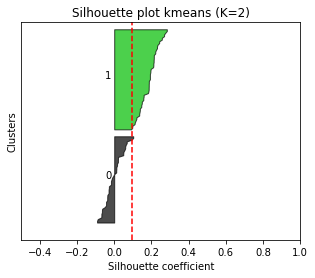

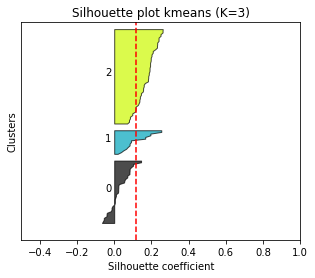

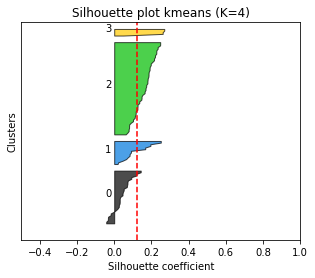

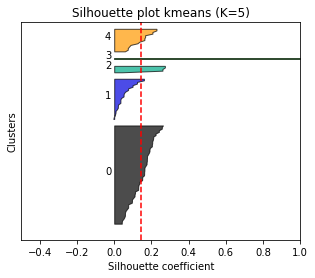

In [34]:
drawSillouette(X, X_kmeans_2, "kmeans (K=2)")
drawSillouette(X, X_kmeans_3, "kmeans (K=3)")
drawSillouette(X, X_kmeans_4, "kmeans (K=4)")
drawSillouette(X, X_kmeans_5, "kmeans (K=5)")

#### 3.1.1.3 What is the best value for k?

- From the analysis above, performing k-means on the full dataset, we obtain the best silhouette score for k=5.
- Albeit not being a very high silhouette score, none of the individual elements have negative silhouette scores, suggesting that they have been attributed to their right cluster.
- A clustering of k=5 has the following cluster distribution: {0: {'ALL': 45, 'AML': 17}, 1: {'ALL': 9, 'AML': 17}, 2: {'AML': 5}, 3: {'ALL': 2}, 4: {'ALL': 14, 'AML': 1}}
- Considering that cluster 4 is a pure ALL cluster (in fact, the AML pacient has been mislabelled in the dataset and is, in fact, a copy of an ALL patient from the same group), we have two ALL clusters (3 and 4), an AML cluster (cluster 2) and two mixed clusters, cluster 0 (more ALL patients) and cluster 1 (with higher number of AML patients). 
- We should highlight here, that using labels to measure the validity of the clustering, can be missleading. If the labels were inappropriately attributed, we will be tempted to force a wrong clustering on the data. Let's not do that!

### 3.1.2 Clustering of the "low-variance" dataset
- We will perform the same analysis on the dataset we produced by eliminating the features showing the lowest variance (variance lower than the average variance of all the features of the dataset).

#### 3.1.2.1 Clustering with K-means (using different values for K)
- We will run K-means with different numbers of clusters and print how the clusters distribute the samples, accordingly to their original label (diagnosis of either ALL or AML).

In [35]:
X_var_kmeans_2 = clusteringKmeans(X_variance, 2)
X_var_kmeans_3 = clusteringKmeans(X_variance, 3)
X_var_kmeans_4 = clusteringKmeans(X_variance, 4)
X_var_kmeans_5 = clusteringKmeans(X_variance, 5)
X_var_kmeans_6 = clusteringKmeans(X_variance, 6)

In [36]:
print("Clusters obtained by k-means with K=2 -->", getLabelsClustering(2, X_var_kmeans_2, y))
print("Clusters obtained by k-means with K=3 -->", getLabelsClustering(3, X_var_kmeans_3, y))
print("Clusters obtained by k-means with K=4 -->", getLabelsClustering(4, X_var_kmeans_4, y))
print("Clusters obtained by k-means with K=5 -->", getLabelsClustering(5, X_var_kmeans_5, y))
print("Clusters obtained by k-means with K=6 -->", getLabelsClustering(6, X_var_kmeans_6, y)) 

Clusters obtained by k-means with K=2 --> {0: {'ALL': 14, 'AML': 1}, 1: {'ALL': 56, 'AML': 39}}
Clusters obtained by k-means with K=3 --> {0: {'ALL': 10, 'AML': 23}, 1: {'ALL': 44, 'AML': 16}, 2: {'ALL': 16, 'AML': 1}}
Clusters obtained by k-means with K=4 --> {0: {'ALL': 13, 'AML': 1}, 1: {'ALL': 17, 'AML': 15}, 2: {'AML': 8}, 3: {'ALL': 40, 'AML': 16}}
Clusters obtained by k-means with K=5 --> {0: {'ALL': 48, 'AML': 19}, 1: {'ALL': 18, 'AML': 2}, 2: {'AML': 5}, 3: {'ALL': 2, 'AML': 14}, 4: {'ALL': 2}}
Clusters obtained by k-means with K=6 --> {0: {'ALL': 12, 'AML': 1}, 1: {'ALL': 16, 'AML': 14}, 2: {'AML': 6}, 3: {'ALL': 40, 'AML': 14}, 4: {'AML': 5}, 5: {'ALL': 2}}


#### 3.1.2.2 Measuring the quality of the clustering using Silhouette score
- We will now use a few functions from our classes, to calculate both the average score and also to visualize the distribution of individual silhouette scores, per clustered samples.

In [37]:
print('For K-means clustering using the X_variance matrix: \n')
for K in range(2, 7, 1):
    kms = KMeans(n_clusters=K, random_state=0).fit(X_variance)
    print("With K=%d, the average silhouette_score is" % K, round(silhouette_score(X_variance, kms.labels_), 3))

For K-means clustering using the X_variance matrix: 

With K=2, the average silhouette_score is 0.199
With K=3, the average silhouette_score is 0.125
With K=4, the average silhouette_score is 0.099
With K=5, the average silhouette_score is 0.166
With K=6, the average silhouette_score is 0.132


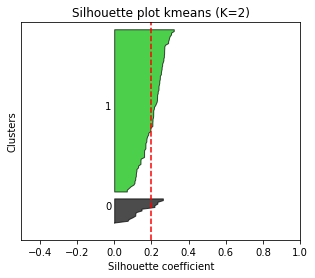

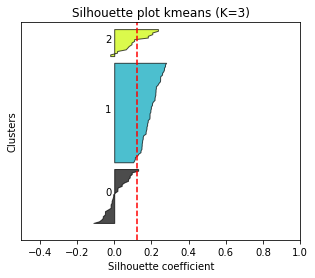

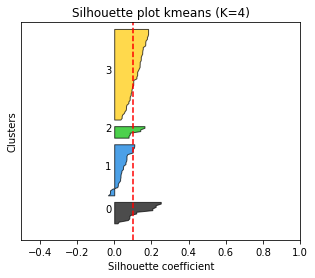

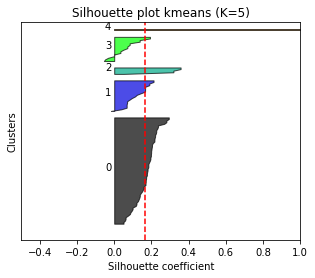

In [38]:
drawSillouette(X_variance, X_var_kmeans_2, "kmeans (K=2)")
drawSillouette(X_variance, X_var_kmeans_3, "kmeans (K=3)")
drawSillouette(X_variance, X_var_kmeans_4, "kmeans (K=4)")
drawSillouette(X_variance, X_var_kmeans_5, "kmeans (K=5)")

#### 3.1.2.3 What is the best value for k?

- From the analysis above, performing k-means on the low variance dataset, we obtain the best silhouette score for k=2. This is actually expected, given several low variance features were removed. This can influence data in two ways: reducing distance between objects; removing features that albeit being low variance, can still be informative. 
- Nevertheless, we can observe that, similarly to what was obtained for the full dataset, a clustering of k=5 gives a relatively high silhouette score. Interestingly, the score for the X_variance dataset is even higher than the similar score for the full dataset.
- A clustering of k=2 has the following cluster distribution: {0: {'ALL': 14, 'AML': 1}, 1: {'ALL': 56, 'AML': 39}}. 
- This mostly separates a cluster of ALL patients (again, the 1 AML is a misslabelled ALL patient) from a big heterogenous cluster of patients.
- A clustering of k=5 has the following distribution: Clusters obtained by k-means with K=5 --> {0: {'ALL': 48, 'AML': 19}, 1: {'ALL': 18, 'AML': 2}, 2: {'AML': 5}, 3: {'ALL': 2, 'AML': 14}, 4: {'ALL': 2}}

### 3.1.3 Clustering of the dataset obtained by dimensionality reduction with PCA
- We will finally perform this analysis on the dataset we obtained by reducing the data using PCA.

#### 3.1.3.1 Clustering with K-means (using different values for K)
- We will run K-means with different numbers of clusters and print how the clusters distribute the samples, accordingly to their original label (diagnosis of either ALL or AML).

In [39]:
X_PCA_kmeans_2 = clusteringKmeans(X_PCA, 2)
X_PCA_kmeans_3 = clusteringKmeans(X_PCA, 3)
X_PCA_kmeans_4 = clusteringKmeans(X_PCA, 4)
X_PCA_kmeans_5 = clusteringKmeans(X_PCA, 5)
X_PCA_kmeans_6 = clusteringKmeans(X_PCA, 6)

In [40]:
print("Clusters obtained by k-means with K=2 -->", getLabelsClustering(2, X_PCA_kmeans_2, y))
print("Clusters obtained by k-means with K=3 -->", getLabelsClustering(3, X_PCA_kmeans_3, y))
print("Clusters obtained by k-means with K=4 -->", getLabelsClustering(4, X_PCA_kmeans_4, y))
print("Clusters obtained by k-means with K=5 -->", getLabelsClustering(5, X_PCA_kmeans_5, y))
print("Clusters obtained by k-means with K=6 -->", getLabelsClustering(6, X_PCA_kmeans_6, y)) 

Clusters obtained by k-means with K=2 --> {0: {'ALL': 28, 'AML': 21}, 1: {'ALL': 42, 'AML': 19}}
Clusters obtained by k-means with K=3 --> {0: {'ALL': 16, 'AML': 1}, 1: {'ALL': 10, 'AML': 27}, 2: {'ALL': 44, 'AML': 12}}
Clusters obtained by k-means with K=4 --> {0: {'ALL': 47, 'AML': 17}, 1: {'ALL': 9, 'AML': 1}, 2: {'ALL': 14, 'AML': 1}, 3: {'AML': 21}}
Clusters obtained by k-means with K=5 --> {0: {'ALL': 35, 'AML': 11}, 1: {'ALL': 20, 'AML': 1}, 2: {'AML': 2}, 3: {'ALL': 13, 'AML': 26}, 4: {'ALL': 2}}
Clusters obtained by k-means with K=6 --> {0: {'ALL': 16, 'AML': 1}, 1: {'ALL': 5, 'AML': 2}, 2: {'ALL': 29, 'AML': 15}, 3: {'AML': 5}, 4: {'ALL': 18, 'AML': 8}, 5: {'ALL': 2, 'AML': 9}}


#### 3.1.3.2 Measuring the quality of the clustering using Silhouette score
- We will now use a few functions from our classes, to calculate both the average score and also to visualize the distribution of individual silhouette scores, per clustered samples.

In [41]:
print('For K-means clustering using the X_PCA matrix: \n')
for K in range(2, 7, 1):
    kms = KMeans(n_clusters=K, random_state=0).fit(X_PCA)
    print("With K=%d, the silhouette_score is" % K, round(silhouette_score(X_PCA, kms.labels_), 3))

For K-means clustering using the X_PCA matrix: 

With K=2, the silhouette_score is 0.155
With K=3, the silhouette_score is 0.172
With K=4, the silhouette_score is 0.188
With K=5, the silhouette_score is 0.179
With K=6, the silhouette_score is 0.121


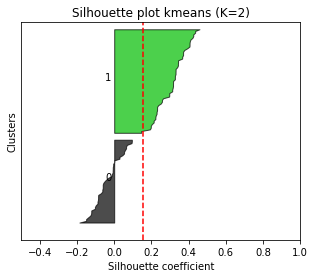

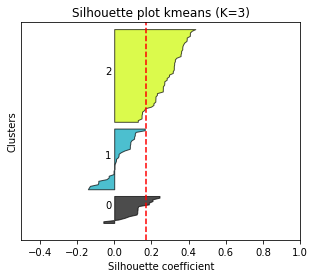

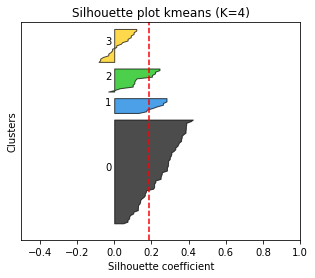

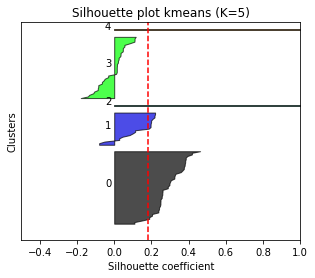

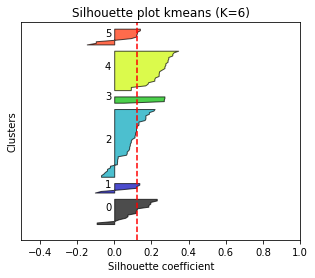

In [42]:
drawSillouette(X_PCA, X_PCA_kmeans_2, "kmeans (K=2)")
drawSillouette(X_PCA, X_PCA_kmeans_3, "kmeans (K=3)")
drawSillouette(X_PCA, X_PCA_kmeans_4, "kmeans (K=4)")
drawSillouette(X_PCA, X_PCA_kmeans_5, "kmeans (K=5)")
drawSillouette(X_PCA, X_PCA_kmeans_6, "kmeans (K=6)")

#### 3.1.3.3 What is the best value for k?

- The X_PCA dataset clustered with k-means, provides us with the highest silhouette scores across all datasets. 
- It also provides us with the most difficult to interpret k value. The differences between k values are low and a choice is difficult to be made.
- If we take the values at face sight, the best value for k is 4. A value of k=5 also seems to be amongst the highest silhouette scores.
- Nevertheless, looking at the silhouette profile, we can see that cluster 3 has lots of individual objects with negative silhouette scores.
- Moreover, the compactness and cluster separation seems to be affected in the X_PCA dataset. In fact, running the k-means multiple times without defining the `random_state=0`, shows that the clustering gives very heterogeneous results, frequently moving objects between clusters. This even happens when defining the random_state.
- A clustering of k=4 gives us the following distributions of patients: {0: {'ALL': 47, 'AML': 17}, 1: {'ALL': 9, 'AML': 1}, 2: {'ALL': 14, 'AML': 1}, 3: {'AML': 21}}

### 3.1.4 Compare the different datasets for the K with the best results.

- We didn't get a single value for k from the different datasets. For the full dataset, we get a k of 5, for the low variance dataset we get a k of 2 and for the PCA dataset we get a k of 4. 
- Nevertheless, across all datasets, a k=5 gives relatively high silhouette scores. Thus, this number of clusters, can be considered for further analysis.
- We got some unexpected results analysing the X_PCA dataset. The clustering of this dataset gives us very labile clusters and it was the dataset that was more complicated to cluster and decide on a good K value. This might be because of the reduction in distance between objects leads to less separated and defined clusters. K-means is known to deal poorly with these.
- We were also surprised with the X_PCA clustering results, as we were expecting the clustering patterns to follow similar patterns to that found for the full dataset (since it's using the same data, projected within a lower dimensional space). 
- The above might be related with the fact that a significant proportion of the dataset is composed of duplicated objects.
- Overall, we found disappointing results for the silhouette scores. Most of the clusterings obtained give objects with negative silhouette scores and the overal scores are generally low. This shows that, regardless of the number of clusters that we considered, clusters are dispersed, overlapping and intracluster cohesion is low.
- If we plot the cluster labels for each dataset for k=5 (see plots below), we can see that the X_PCA clustering produces more compact and defined clusters. We have to keep in mind that the visualization we are showing only takes the 2 first components into consideration. So, this observation has to be taken with a grain of salt.

#### In conclusion, for partitional clustering, it is hard to determine which dataset gives us the best clustering of our data. If we restrict ourselves to the analysis of the silhouette values, X_PCA gives us the highest values (even if choosing one value for K is more difficult to achieve). Looking at the clustering of the patients (on the 1st two principal components of the data), the clusters formed with the X_PCA dataset are, indeed, more compact. As we mentioned, this has to be taken with caution. Also, from the analysis of all datasets, there are a few values of k that are interesting and should be tested further: k=2 and k=5.
#### We will discuss the biological relevance of these conclusions when we have collected more information about clustering and clustering quality metrics.

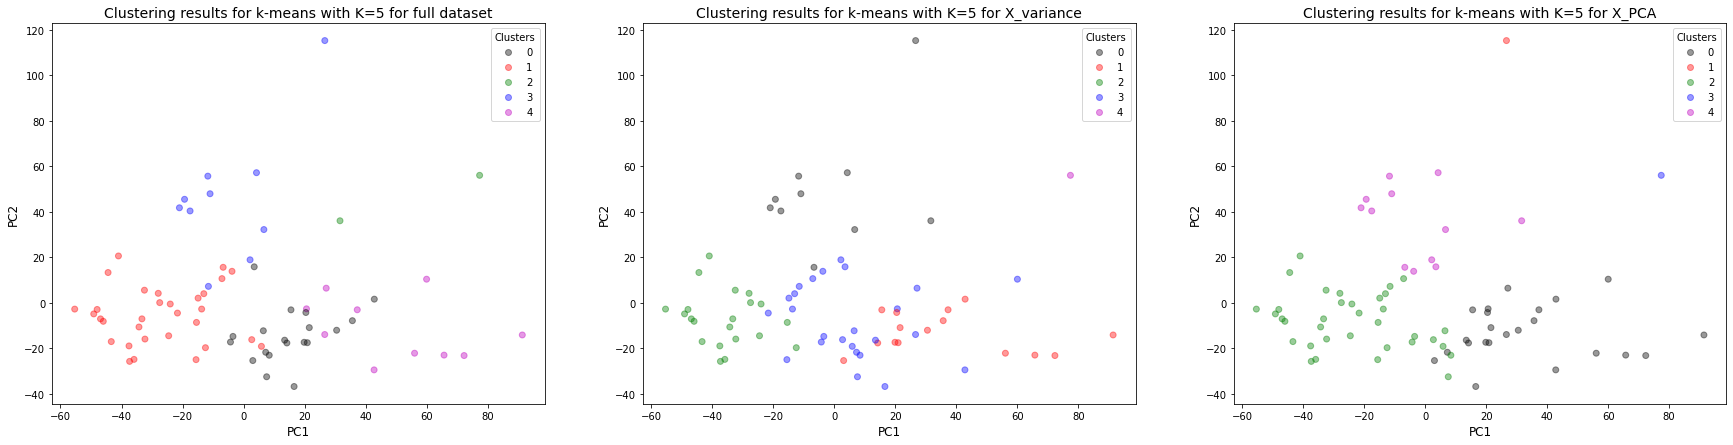

In [57]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans

K=5
kmeans = KMeans(n_clusters=K, random_state=0)

kmeansX = kmeans.fit(X)
valuesX = list(kmeansX.labels_)
classesX = set(kmeansX.labels_)

kmeansVar = kmeans.fit(X_variance)
valuesVar = list(kmeansVar.labels_)
classesVar = set(kmeansVar.labels_)

kmeansPCA = kmeans.fit(X_PCA)
valuesPCA = list(kmeansPCA.labels_)
classesPCA = set(kmeansPCA.labels_)

colours = ListedColormap(["k", "r", "g", "b", "m"])

fig = plt.figure(figsize=(30,7))

fig = plt.subplot(1, 3, 1)
scatter = plt.scatter(X_PCA[:, 0], X_PCA[:, 1], alpha=0.4, c=valuesX, cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=classesX, title='Clusters')
plt.title("Clustering results for k-means with K=5 for full dataset", fontsize=14)
plt.xlabel('PC1', fontsize = 12)
plt.ylabel('PC2', fontsize = 12)

fig = plt.subplot(1, 3, 2)
scatter = plt.scatter(X_PCA[:, 0], X_PCA[:, 1], alpha=0.4, c=valuesVar, cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=classesVar, title='Clusters')
plt.title("Clustering results for k-means with K=5 for X_variance", fontsize=14)
plt.xlabel('PC1', fontsize = 12)
plt.ylabel('PC2', fontsize = 12)

fig = plt.subplot(1, 3, 3)
scatter = plt.scatter(X_PCA[:, 0], X_PCA[:, 1], alpha=0.4, c=valuesPCA, cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=classesPCA, title='Clusters')
plt.title("Clustering results for k-means with K=5 for X_PCA", fontsize=14)
plt.xlabel('PC1', fontsize = 12)
plt.ylabel('PC2', fontsize = 12)

plt.show()

## 4. Clustering Patients using Hierarchical Clustering

Use a **Hierarchical Clustering Algorithm (HCA)** to cluster the patients: 

* Cluster the data in **X_variance**.
    * Use **different linkage metrics**.
    * Use different values of `K`.
    * For each linkage metric and value of `K` present the clustering by specifying how many patients ALL and AML are in each cluster as you did before. 
    * What is the best linkage metric and the best value of `K`? Justify using the clustering results and the [Silhouette score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).

* Cluster the data in **X_PCA**.
    * Study different linkage metrics and different values of `K` as above.

* Compare the results obtained in the two datasets above for the best linkage metric and the best `K`. Discuss.

### 4.1 Clustering using Hierarchical Clustering

The process of HCA is quite simple, and consists of the following steps:
- Inicialization: Each object is a cluster
- Create Distance Matrix: Compute pairwise distances between the clusters
- Identify the closest clusters
- Join the closest clusters
- Recompute the distances from the new cluster to the other clusters
- Repeat 3 to 5 until all all clusters are merged (or a predefined number of clusters is reached)

As we can understand, from the explanation above, it is a bottom-up approach of clustering that doesn't require prior knowledge about the number of clusters in the data.

Regarding the different linkage metrics, these determine which distance to use between sets of observation. The algorithm will merge the pairs of clusters that minimize this criterion. The available algorithms are:
- ward - minimizes the variance of the clusters being merged.
- average - uses the average of the distances of each observation of the two sets.
- complete or maximum linkage - uses the maximum distances between all observations of the two sets.
- single - uses the minimum of the distances between all observations of the two sets.

Let's start by creating some functions to help us run our HCA clustering.

In [47]:
from sklearn.cluster import AgglomerativeClustering

def clusteringHCA (dataset, k, linkage, affinity = 'euclidean'):
    """
    This function runs the HCA algorithm from scikit learn and clusters the data
    in k clusters.
    Requires: A data matrix in which each line is an element of the dataset. a k value that is an int (number of clusters).
    Ensures: Provides a vector with the clusters to which each element were attributed.
    """
    cluster = AgglomerativeClustering(n_clusters = k, linkage = linkage, affinity = affinity)  
    cluster.fit_predict(dataset)
    l = cluster.labels_
    return l

### 4.1.1 Clustering of the "low-variance" dataset with HCA

#### To help us visualize the clustering performed by HCA we will use a dendogram, a visualization in form of a tree showing the order and distances of merges during the hierarchical clustering.
- We will create a dendogram for all differente linkage metrics in order to decide which ones to analyze further.

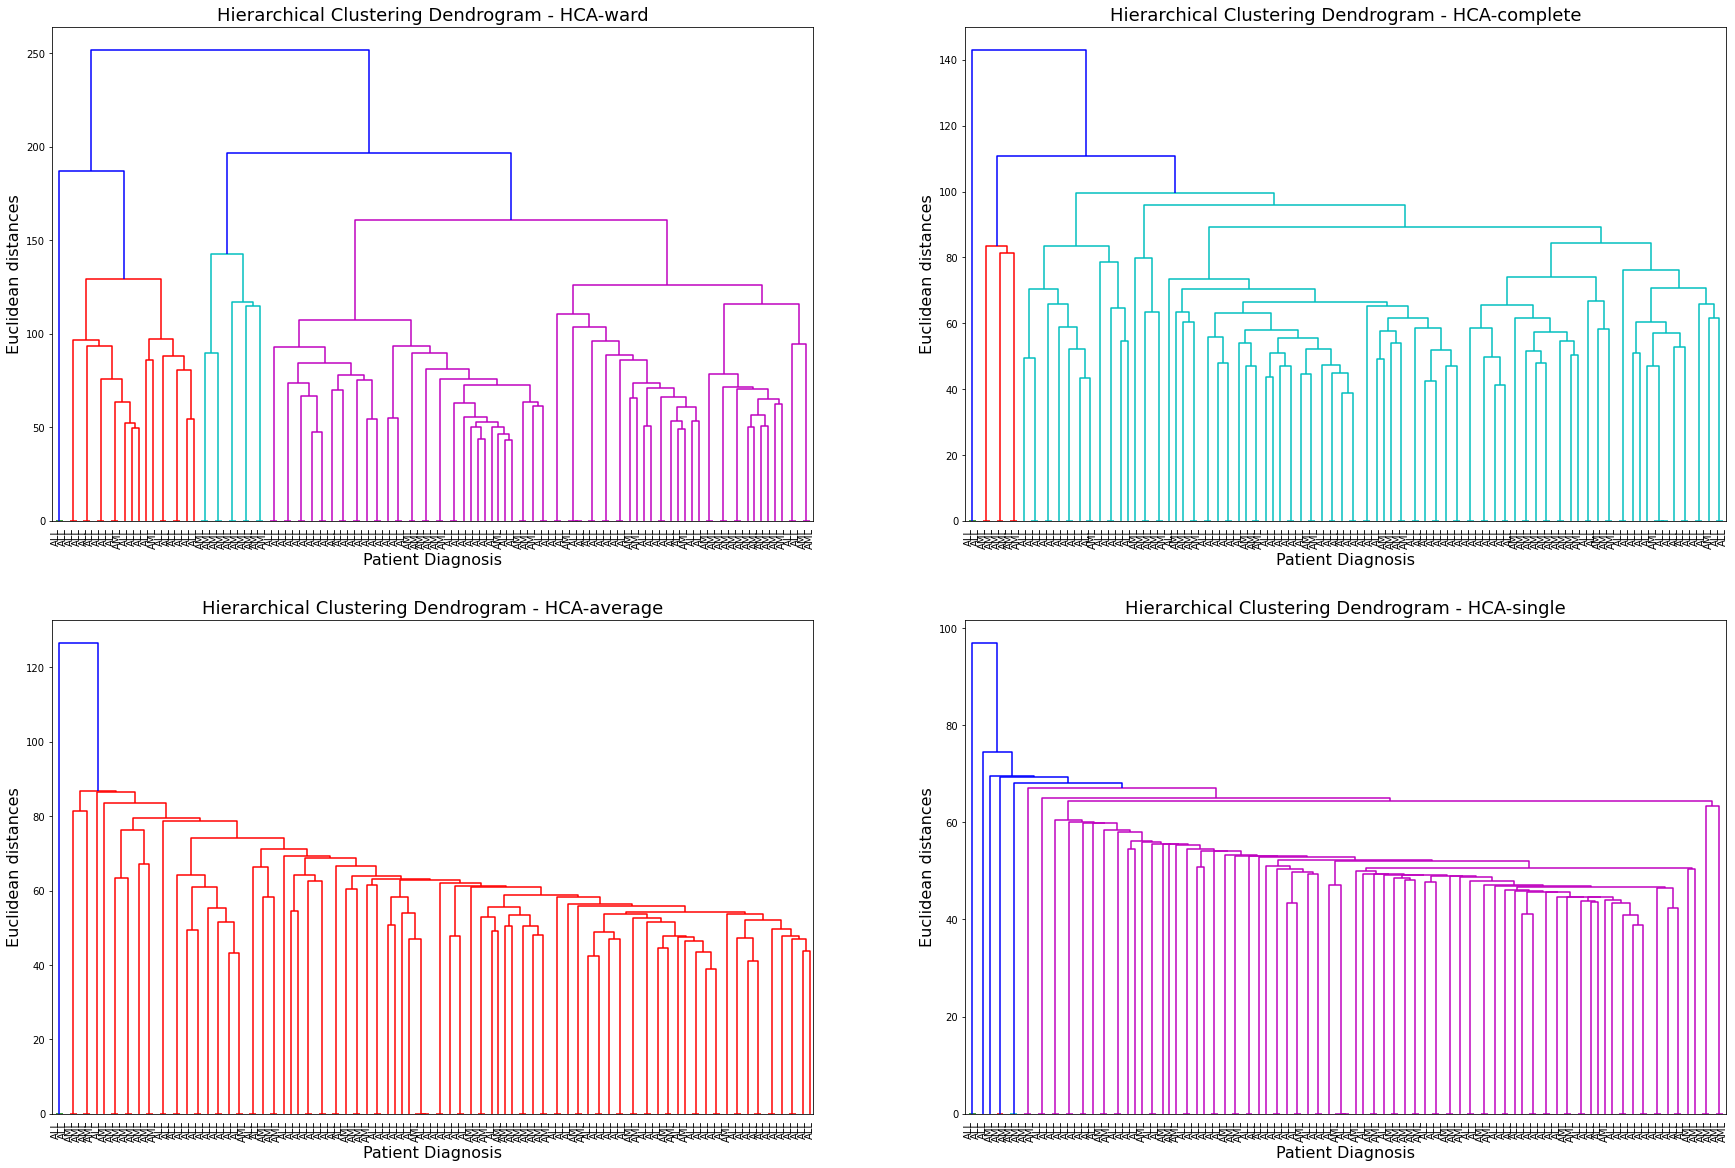

In [48]:
import scipy.cluster.hierarchy as hierarchy
from sklearn.cluster import AgglomerativeClustering

dataset = X_variance
labelList = y
linkedWard = hierarchy.linkage(dataset, method = 'ward')
linkedComplete = hierarchy.linkage(dataset, method = 'complete')
linkedAverage = hierarchy.linkage(dataset, method = 'average')
linkedSingle = hierarchy.linkage(dataset, method = 'single')

plt.figure(figsize=(30,20))

plt.subplot(2, 2, 1)
hierarchy.dendrogram(linkedWard, labels=labelList, distance_sort="descending", show_leaf_counts=False, leaf_rotation=90., leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram - HCA-ward', fontsize=18)
plt.xlabel('Patient Diagnosis', fontsize=16)
plt.ylabel('Euclidean distances', fontsize=16)

plt.subplot(2, 2, 2)
hierarchy.dendrogram(linkedComplete, labels=labelList, distance_sort="descending", show_leaf_counts=False, leaf_rotation=90., leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram - HCA-complete', fontsize=18)
plt.xlabel('Patient Diagnosis', fontsize=16)
plt.ylabel('Euclidean distances', fontsize=16)

plt.subplot(2, 2, 3)
hierarchy.dendrogram(linkedAverage, labels=labelList, distance_sort="descending", show_leaf_counts=False, leaf_rotation=90., leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram - HCA-average', fontsize=18)
plt.xlabel('Patient Diagnosis', fontsize=16)
plt.ylabel('Euclidean distances', fontsize=16)

plt.subplot(2, 2, 4)
hierarchy.dendrogram(linkedSingle, labels=labelList, distance_sort="descending", show_leaf_counts=False, leaf_rotation=90., leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram - HCA-single', fontsize=18)
plt.xlabel('Patient Diagnosis', fontsize=16)
plt.ylabel('Euclidean distances', fontsize=16)

plt.show()

### There are a few observation that we can immediately make from the analysis of the dendograms:
- Out of all linkage metrics, only the Ward method gives us a decent looking hierarchical structure. 
- Using the Ward method, we can visualize 3 main groups.
- The dendograms do an excellent job at exposing the problem of the dataset. Several duplicated individuals (and we can even see the duplicated patient that has been labelled as AML, in the red ALL group in the ward dendogram).

### With this in mind, we will continue our analysis focusing solely on the Ward linkage metrics.

- We will start by clustering the dataset obtained from eliminating features with a low variance (below the average variance of the dataset), using the HCA algorithm. We will analyse the clusters identified by comparing to the labels (diagnosis) of the individuals. 
- As we have mentioned above, we will only carry on analysing HCA with the ward metrics. 
- We will finally use unsurpervised metrics, to measure the quality of the clustering for different values of k. For this, we will use the Silhouette score metrics, as above.

#### 4.1.1.1 Clustering with HCA using Ward’s minimum variance method (and different values of K)

In [50]:
X_var_HCA_ward_2 = clusteringHCA(X_variance, 2, 'ward')
X_var_HCA_ward_3 = clusteringHCA(X_variance, 3, 'ward')
X_var_HCA_ward_4 = clusteringHCA(X_variance, 4, 'ward')
X_var_HCA_ward_5 = clusteringHCA(X_variance, 5, 'ward')
X_var_HCA_ward_6 = clusteringHCA(X_variance, 6, 'ward')

In [51]:
print("Clusters obtained by HCA-ward with K=2 -->", getLabelsClustering(2, X_var_HCA_ward_2, y))
print("Clusters obtained by HCA-ward with K=3 -->", getLabelsClustering(3, X_var_HCA_ward_3, y))
print("Clusters obtained by HCA-ward with K=4 -->", getLabelsClustering(4, X_var_HCA_ward_4, y))
print("Clusters obtained by HCA-ward with K=5 -->", getLabelsClustering(5, X_var_HCA_ward_5, y))
print("Clusters obtained by HCA-ward with K=6 -->", getLabelsClustering(6, X_var_HCA_ward_6, y)) 

Clusters obtained by HCA-ward with K=2 --> {0: {'ALL': 51, 'AML': 38}, 1: {'ALL': 19, 'AML': 2}}
Clusters obtained by HCA-ward with K=3 --> {0: {'ALL': 19, 'AML': 2}, 1: {'ALL': 51, 'AML': 28}, 2: {'AML': 10}}
Clusters obtained by HCA-ward with K=4 --> {0: {'ALL': 51, 'AML': 28}, 1: {'ALL': 17, 'AML': 2}, 2: {'AML': 10}, 3: {'ALL': 2}}
Clusters obtained by HCA-ward with K=5 --> {0: {'AML': 10}, 1: {'ALL': 17, 'AML': 2}, 2: {'ALL': 20, 'AML': 18}, 3: {'ALL': 2}, 4: {'ALL': 31, 'AML': 10}}
Clusters obtained by HCA-ward with K=6 --> {0: {'ALL': 17, 'AML': 2}, 1: {'AML': 6}, 2: {'ALL': 20, 'AML': 18}, 3: {'ALL': 2}, 4: {'ALL': 31, 'AML': 10}, 5: {'AML': 4}}


In [52]:
print('For HCA clustering using ward method over the X_variance matrix: \n')
for K in range(2,7,1):
    hca = AgglomerativeClustering(n_clusters = K, linkage = "ward").fit(X_variance)  
    sil_hca = silhouette_score(X_variance, hca.labels_)
    print("With K=%d, the average silhouette_score is" % K, round(silhouette_score(X_variance, hca.labels_), 3))

For HCA clustering using ward method over the X_variance matrix: 

With K=2, the average silhouette_score is 0.166
With K=3, the average silhouette_score is 0.175
With K=4, the average silhouette_score is 0.167
With K=5, the average silhouette_score is 0.097
With K=6, the average silhouette_score is 0.116


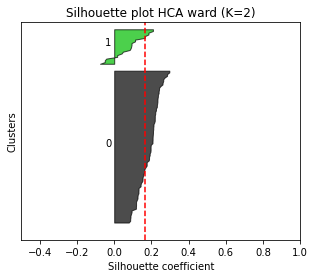

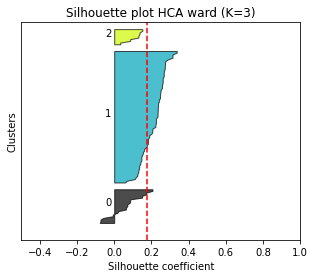

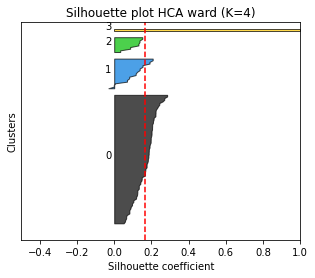

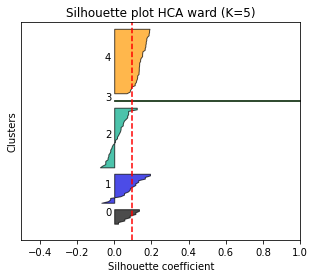

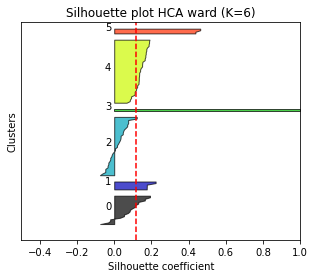

In [53]:
drawSillouette(X_variance, X_var_HCA_ward_2, "HCA ward (K=2)")
drawSillouette(X_variance, X_var_HCA_ward_3, "HCA ward (K=3)")
drawSillouette(X_variance, X_var_HCA_ward_4, "HCA ward (K=4)")
drawSillouette(X_variance, X_var_HCA_ward_5, "HCA ward (K=5)")
drawSillouette(X_variance, X_var_HCA_ward_6, "HCA ward (K=6)")

#### 4.1.1.2 Comparing linkage metrics and values of k
From the analysis of the HCA clustering on the X_variance dataset, we can conclude:

- Most of the linkage metrics are unusable, for this clustering. Ward is the only metrics that gives us, what seems like, an acceptable clustering.
- The best silhouette score is obtained for k=3. This isn't surprising, and could be predicted from the dendograms above.
- For k=3, we obtain the following distribution of patients by cluster: {0: {'ALL': 19, 'AML': 2}, 1: {'ALL': 51, 'AML': 28}, 2: {'AML': 10}}
- Looking at this clustering distribution, it seems we mostly have an ALL cluster (cluster 0), an AML cluster (cluster 2) and an heterogeneous cluster. 

### 4.1.2 Clustering of the dataset obtained by PCA dimensionality reduction with HCA
- Let's start by analyzing the clustering by visualizing the dendograms for the different linkage metrics.

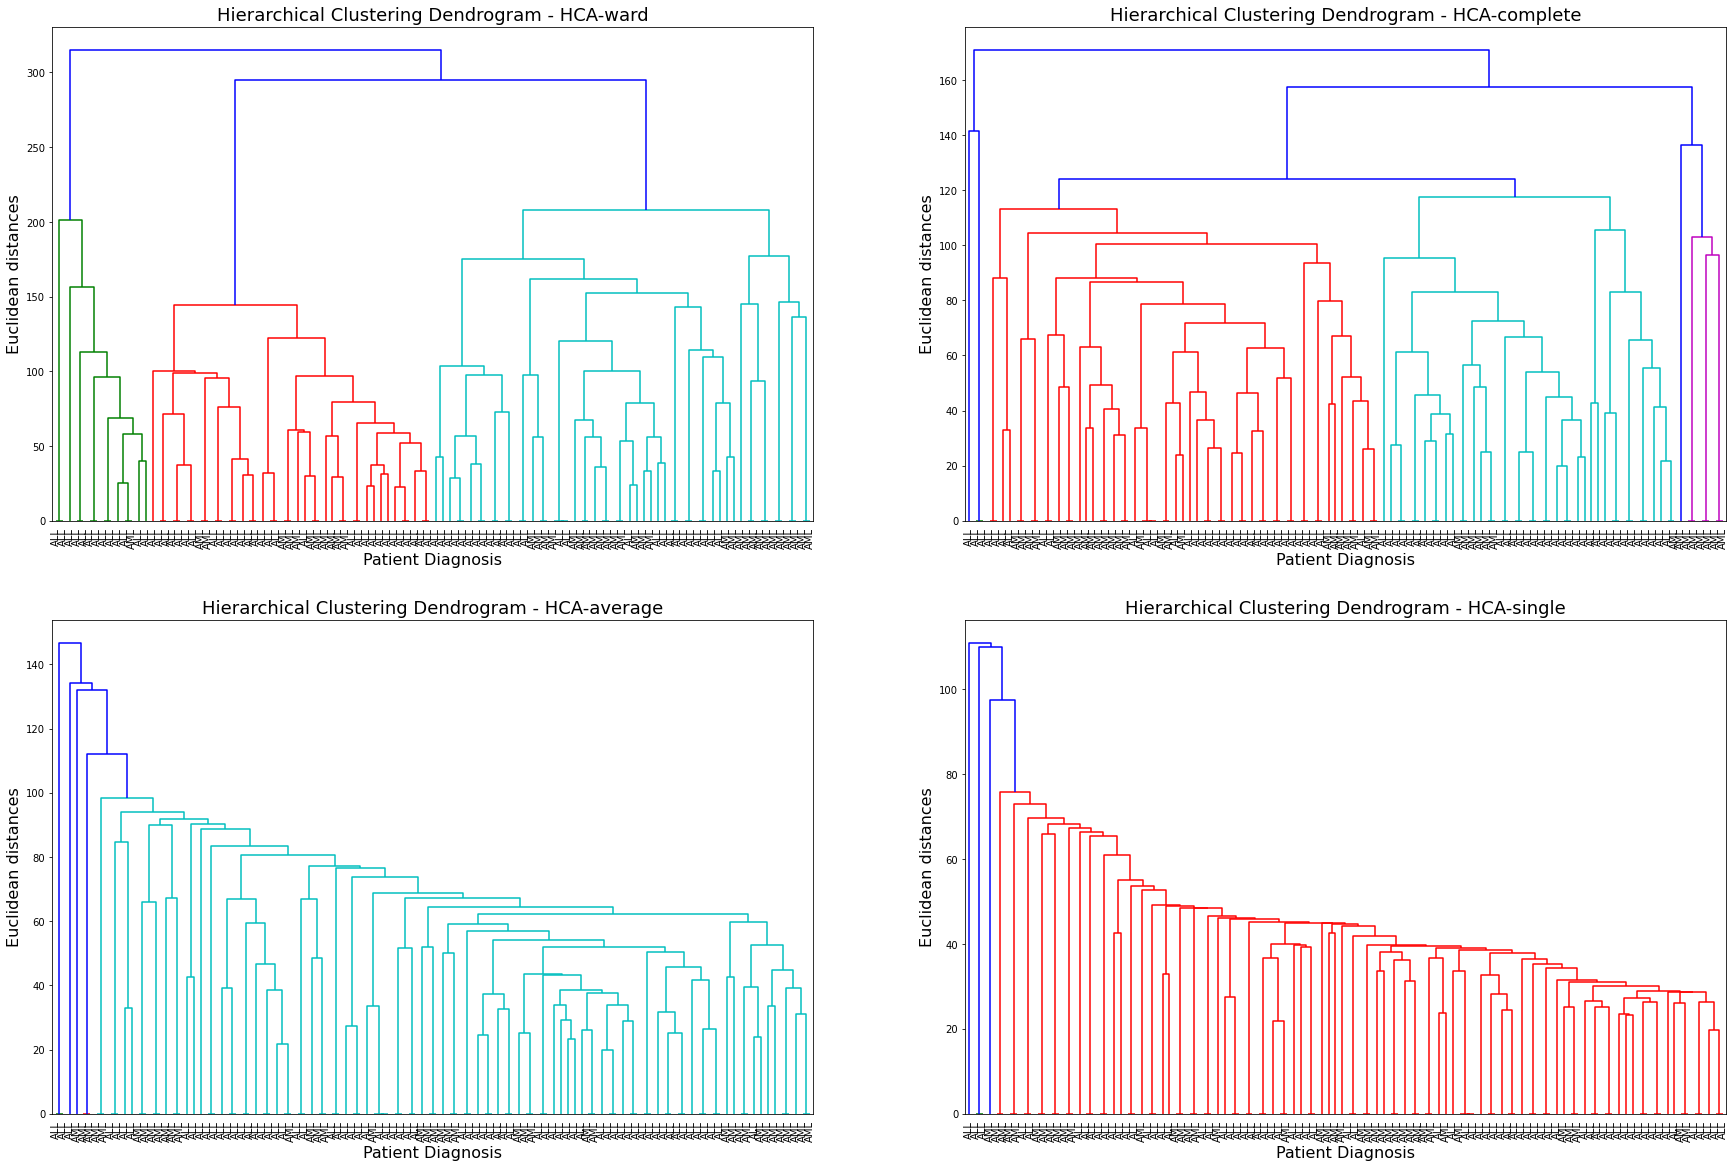

In [55]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

dataset = X_PCA
labelList = y
linkedWard = sch.linkage(dataset, method = 'ward')
linkedComplete = sch.linkage(dataset, method = 'complete')
linkedAverage = sch.linkage(dataset, method = 'average')
linkedSingle = sch.linkage(dataset, method = 'single')

plt.figure(figsize=(30,20))

plt.subplot(2, 2, 1)
hierarchy.dendrogram(linkedWard, labels=labelList, distance_sort="descending", show_leaf_counts=False, leaf_rotation=90., leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram - HCA-ward', fontsize=18)
plt.xlabel('Patient Diagnosis', fontsize=16)
plt.ylabel('Euclidean distances', fontsize=16)

plt.subplot(2, 2, 2)
hierarchy.dendrogram(linkedComplete, labels=labelList, distance_sort="descending", show_leaf_counts=False, leaf_rotation=90., leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram - HCA-complete', fontsize=18)
plt.xlabel('Patient Diagnosis', fontsize=16)
plt.ylabel('Euclidean distances', fontsize=16)

plt.subplot(2, 2, 3)
hierarchy.dendrogram(linkedAverage, labels=labelList, distance_sort="descending", show_leaf_counts=False, leaf_rotation=90., leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram - HCA-average', fontsize=18)
plt.xlabel('Patient Diagnosis', fontsize=16)
plt.ylabel('Euclidean distances', fontsize=16)

plt.subplot(2, 2, 4)
hierarchy.dendrogram(linkedSingle, labels=labelList, distance_sort="descending", show_leaf_counts=False, leaf_rotation=90., leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram - HCA-single', fontsize=18)
plt.xlabel('Patient Diagnosis', fontsize=16)
plt.ylabel('Euclidean distances', fontsize=16)

plt.show()

#### We can observe that, similarly to the analysis performed for the X_variance dataset, the ward metrics looks like the most adequate. Nevertheless, the complete linkage also gives us potentially usable results.

- We will next perform the same analysis as in the point 4.1.1.1, for the dataset obtained by dimensionality reduction using the first 23 components of PCA dimensionality reduction. We will analyse the clusters identified by comparing to the labels (diagnosis) of the individuals. 
- We will do our analysis using the linkage metrics `ward` and `complete`.
- We will use unsurpervised metrics, to measure the quality of the clustering. For this, we will use the Silhouette score metrics, as above.

#### 4.1.2.1 Clustering with HCA using Ward’s minimum variance method (and different values of K)

In [56]:
X_PCA_HCA_ward_2 = clusteringHCA(X_PCA, 2, 'ward')
X_PCA_HCA_ward_3 = clusteringHCA(X_PCA, 3, 'ward')
X_PCA_HCA_ward_4 = clusteringHCA(X_PCA, 4, 'ward')
X_PCA_HCA_ward_5 = clusteringHCA(X_PCA, 5, 'ward')
X_PCA_HCA_ward_6 = clusteringHCA(X_PCA, 6, 'ward')

In [57]:
print("Clusters obtained by HCA-ward with K=2 -->", getLabelsClustering(2, X_PCA_HCA_ward_2, y))
print("Clusters obtained by HCA-ward with K=3 -->", getLabelsClustering(3, X_PCA_HCA_ward_3, y))
print("Clusters obtained by HCA-ward with K=4 -->", getLabelsClustering(4, X_PCA_HCA_ward_4, y))
print("Clusters obtained by HCA-ward with K=5 -->", getLabelsClustering(5, X_PCA_HCA_ward_5, y))
print("Clusters obtained by HCA-ward with K=6 -->", getLabelsClustering(6, X_PCA_HCA_ward_6, y)) 

Clusters obtained by HCA-ward with K=2 --> {0: {'ALL': 57, 'AML': 39}, 1: {'ALL': 13, 'AML': 1}}
Clusters obtained by HCA-ward with K=3 --> {0: {'ALL': 27, 'AML': 28}, 1: {'ALL': 13, 'AML': 1}, 2: {'ALL': 30, 'AML': 11}}
Clusters obtained by HCA-ward with K=4 --> {0: {'ALL': 13, 'AML': 1}, 1: {'AML': 11}, 2: {'ALL': 30, 'AML': 11}, 3: {'ALL': 27, 'AML': 17}}
Clusters obtained by HCA-ward with K=5 --> {0: {'AML': 11}, 1: {'ALL': 27, 'AML': 17}, 2: {'ALL': 30, 'AML': 11}, 3: {'ALL': 11, 'AML': 1}, 4: {'ALL': 2}}
Clusters obtained by HCA-ward with K=6 --> {0: {'ALL': 27, 'AML': 17}, 1: {'ALL': 11, 'AML': 1}, 2: {'AML': 5}, 3: {'AML': 6}, 4: {'ALL': 2}, 5: {'ALL': 30, 'AML': 11}}


In [58]:
print('For HCA clustering using ward method over the X_PCA matrix: \n')
for K in range(2,7,1):
    hca = AgglomerativeClustering(n_clusters = K, linkage = "ward").fit(X_PCA)  
    sil_hca = silhouette_score(X_PCA, hca.labels_)
    print("With K=%d, the average silhouette_score is" % K, round(silhouette_score(X_PCA, hca.labels_), 3))

For HCA clustering using ward method over the X_PCA matrix: 

With K=2, the average silhouette_score is 0.233
With K=3, the average silhouette_score is 0.129
With K=4, the average silhouette_score is 0.131
With K=5, the average silhouette_score is 0.154
With K=6, the average silhouette_score is 0.172


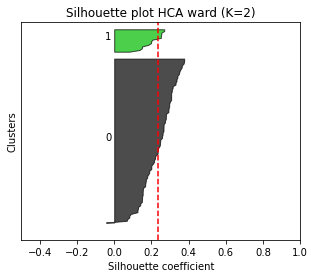

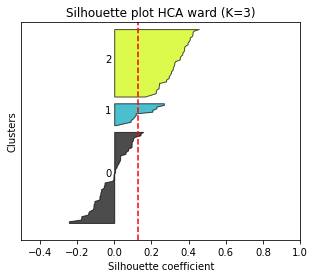

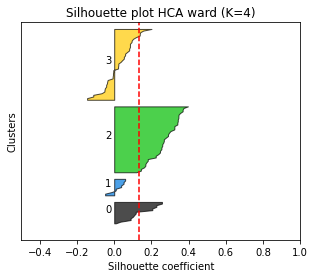

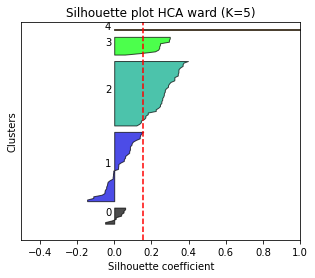

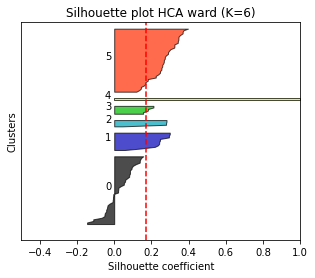

In [59]:
drawSillouette(X_PCA, X_PCA_HCA_ward_2, "HCA ward (K=2)")
drawSillouette(X_PCA, X_PCA_HCA_ward_3, "HCA ward (K=3)")
drawSillouette(X_PCA, X_PCA_HCA_ward_4, "HCA ward (K=4)")
drawSillouette(X_PCA, X_PCA_HCA_ward_5, "HCA ward (K=5)")
drawSillouette(X_PCA, X_PCA_HCA_ward_6, "HCA ward (K=6)")

#### 4.1.2.2 Clustering with HCA using complete linkage (and different values of K)

In [60]:
X_PCA_HCA_complete_2 = clusteringHCA(X_PCA, 2, 'complete')
X_PCA_HCA_complete_3 = clusteringHCA(X_PCA, 3, 'complete')
X_PCA_HCA_complete_4 = clusteringHCA(X_PCA, 4, 'complete')
X_PCA_HCA_complete_5 = clusteringHCA(X_PCA, 5, 'complete')
X_PCA_HCA_complete_6 = clusteringHCA(X_PCA, 6, 'complete')

In [61]:
print("Clusters obtained by HCA-complete with K=2 -->", getLabelsClustering(2, X_PCA_HCA_complete_2, y))
print("Clusters obtained by HCA-complete with K=3 -->", getLabelsClustering(3, X_PCA_HCA_complete_3, y))
print("Clusters obtained by HCA-complete with K=4 -->", getLabelsClustering(4, X_PCA_HCA_complete_4, y))
print("Clusters obtained by HCA-complete with K=5 -->", getLabelsClustering(5, X_PCA_HCA_complete_5, y))
print("Clusters obtained by HCA-complete with K=6 -->", getLabelsClustering(6, X_PCA_HCA_complete_6, y)) 

Clusters obtained by HCA-complete with K=2 --> {0: {'ALL': 67, 'AML': 40}, 1: {'ALL': 3}}
Clusters obtained by HCA-complete with K=3 --> {0: {'ALL': 3}, 1: {'AML': 7}, 2: {'ALL': 67, 'AML': 33}}
Clusters obtained by HCA-complete with K=4 --> {0: {'AML': 7}, 1: {'ALL': 2}, 2: {'ALL': 67, 'AML': 33}, 3: {'ALL': 1}}
Clusters obtained by HCA-complete with K=5 --> {0: {'ALL': 67, 'AML': 33}, 1: {'ALL': 2}, 2: {'AML': 6}, 3: {'ALL': 1}, 4: {'AML': 1}}
Clusters obtained by HCA-complete with K=6 --> {0: {'ALL': 36, 'AML': 7}, 1: {'ALL': 2}, 2: {'ALL': 31, 'AML': 26}, 3: {'ALL': 1}, 4: {'AML': 1}, 5: {'AML': 6}}


In [62]:
print('For HCA clustering using a complete linkage over the X_PCA matrix : \n')
for K in range(2,7,1):
    hca = AgglomerativeClustering(n_clusters = K, linkage = "complete").fit(X_PCA)  
    sil_hca = silhouette_score(X_PCA, hca.labels_)
    print("With K=%d, the average silhouette_score is" % K, round(silhouette_score(X_PCA, hca.labels_), 3))

For HCA clustering using a complete linkage over the X_PCA matrix : 

With K=2, the average silhouette_score is 0.454
With K=3, the average silhouette_score is 0.312
With K=4, the average silhouette_score is 0.321
With K=5, the average silhouette_score is 0.302
With K=6, the average silhouette_score is 0.1


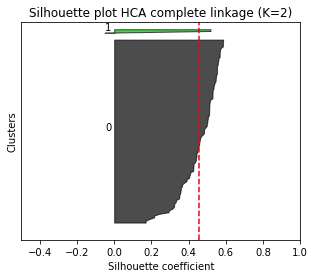

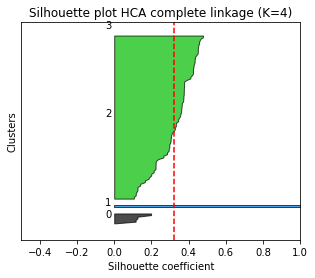

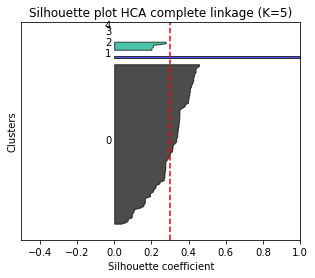

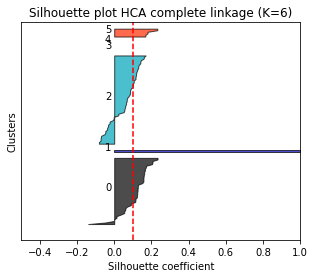

In [63]:
drawSillouette(X_PCA, X_PCA_HCA_complete_2, "HCA complete linkage (K=2)")
drawSillouette(X_PCA, X_PCA_HCA_complete_4, "HCA complete linkage (K=4)")
drawSillouette(X_PCA, X_PCA_HCA_complete_5, "HCA complete linkage (K=5)")
drawSillouette(X_PCA, X_PCA_HCA_complete_6, "HCA complete linkage (K=6)")

#### 4.1.2.3 Comparing linkage metrics and values of k
From the analysis of the results above, we conclude that:
- As for the clustering using k-means, it seems that the HCA clustering for the X_PCA dataset, seems to find a more difficult time alocating objects to their right clusters.
- By looking at the silhouette profiles of the complete linkage, we observe that, similarly to the HCA for the X_variance dataset, most of the objects are clustered together. We will thus discard this metric from our analysis and restrict our analysis to the use of the `ward` metrics.
- For the ward metrics, the best silhouette score is achieved with k=2. The higher value of this score is due to the fact that most of the objects are clustered in one single cluster. Therefore, we will look into other values of k.
- Here, we have the same problem as the k-means clustering for the X_PCA dataset: as the number of clusters increase, the silhouette score increases as well. This makes the choice of the best k, very complicated.
- For the sake of simplicity, and to be able to compare the different clustering algorithms, we will set on k=5 (even knowing it's not the best score).
- For k=5, we get the following clustering of patients: {0: {'AML': 11}, 1: {'ALL': 27, 'AML': 20}, 2: {'ALL': 30, 'AML': 8}, 3: {'ALL': 11, 'AML': 1}, 4: {'ALL': 2}}

### 4.1.3 Discuss the HCA clustering results


- Our analysis using HCA clustering shown us, beforehand, that most of the linkage metrics used give us very poor clustering results. Most of the metrics tested are not great when dealing with noisy data (which is the case in hand).
- Our analysis using the ward linkage metrics, gives us different results when clustering the X_variance and X_PCA datasets. 
- The X_variance gives a higher silhouette value for k=3, whereas the X_PCA gives higher values for k=2, k=3 or k=4, making it difficult to pick appart the best k value.
- The combined analysis of the silhouette profiles, average silhouette scores and dendograms, makes us shortlist as potentially interesting k values, k=2, k=3 and k=5, that we will test further in the next sections.
- Again, similarly to what was observed for the k-means clustering, the X_PCA clustering is harder to accomplish.
- The silhouette scores are also somehow disappointing. Several objects have negative silhouette scores, across most of the clustering methods and datasets. This confirms the notion that this dataset is noisy (and adding duplicated values to it, likely contributes to this). This is reflected in dispersed clusters, not well defined and with low cohesion.
- If we plot the cluster labels for each dataset for k=3 and k=5 (see plots below), we can see that the X_PCA clustering produces more compact and defined clusters for k=3. For k=5, the individuals seem to be distributed into similar clusters. Again, we have to keep in mind that the visualization we are showing only takes the 2 first components into consideration. 

#### In conclusion, for hierarchical clustering, once again, it's hard to determine which dataset gives us the best clustering of the data. As we feel that removing features based solely on their variance can hinder the natural distribution of the sample space, we will discard this dataset from further analysis and focus only on the X_PCA dataset. Besides this, the fact that the silhouette values and clusters look better (or as good) compared to those obtained from the X_variance, for different values of k, reassures us of our decision to focus on this dataset. Moreover, we will focus on 2, 3 and 5 clusters in our further analysis.

#### As for the previous section, we will focus on discussing the biological relevance of the clustering in the following sections of the project.

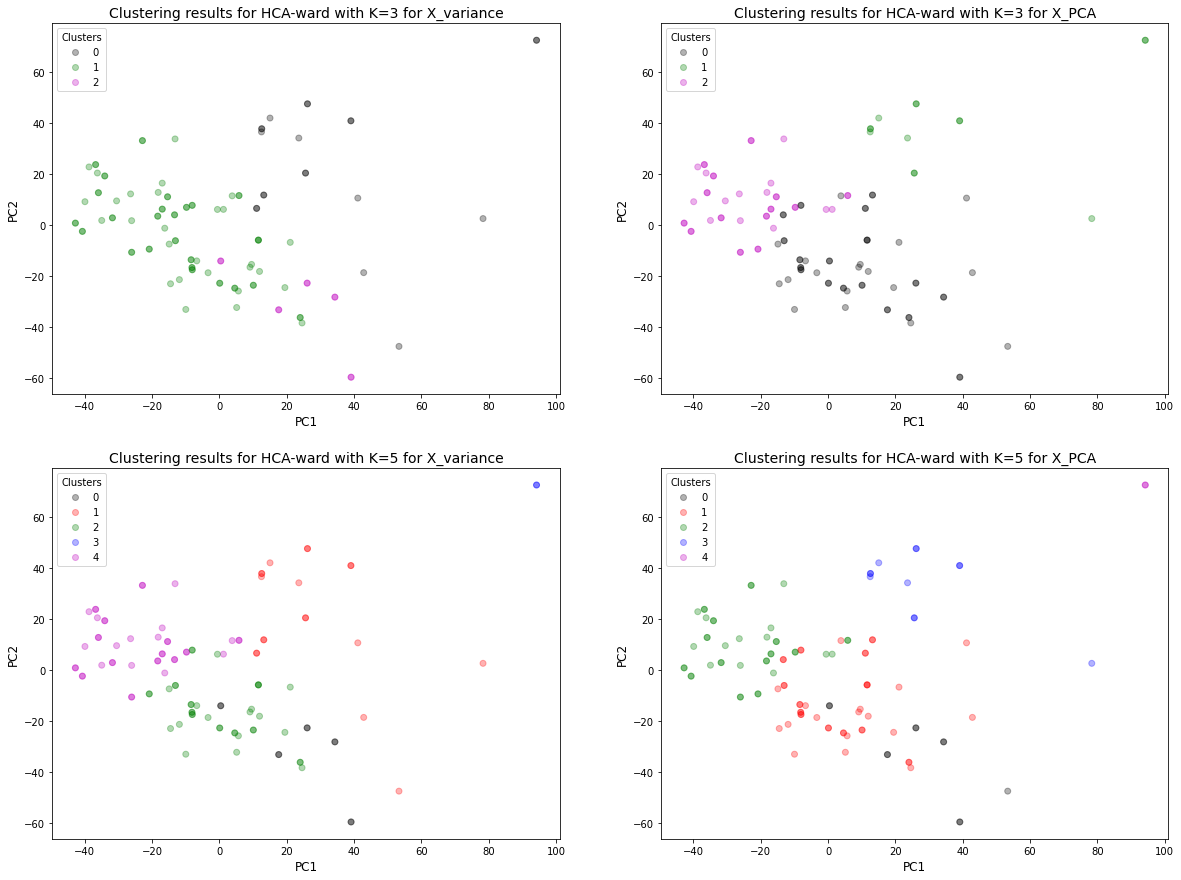

In [64]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans


HcaVar = AgglomerativeClustering(n_clusters = 3, linkage = 'ward')  
HcaVar = HcaVar.fit(X_variance)
values = list(HcaVar.labels_)
classes = set(HcaVar.labels_)
colours = ListedColormap(["k", "r", "g", "b", "m"])

fig = plt.figure(figsize=(20, 15))

fig = plt.subplot(2, 2, 1)
scatter = plt.scatter(X_PCA[:, 0], X_PCA[:, 1], alpha=0.3, c=values, cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=classes, title='Clusters')
plt.title("Clustering results for HCA-ward with K=3 for X_variance", fontsize=14)
plt.xlabel('PC1', fontsize = 12)
plt.ylabel('PC2', fontsize = 12)



HcaVar = AgglomerativeClustering(n_clusters = 3, linkage = 'ward')  
HcaVar = HcaVar.fit(X_PCA)
values = list(HcaVar.labels_)
classes = set(HcaVar.labels_)
colours = ListedColormap(["k", "r", "g", "b", "m"])

fig = plt.subplot(2, 2, 2)
scatter = plt.scatter(X_PCA[:, 0], X_PCA[:, 1], alpha=0.3, c=values, cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=classes, title='Clusters')
plt.title("Clustering results for HCA-ward with K=3 for X_PCA", fontsize=14)
plt.xlabel('PC1', fontsize = 12)
plt.ylabel('PC2', fontsize = 12)


HcaVar = AgglomerativeClustering(n_clusters = 5, linkage = 'ward')  
HcaVar = HcaVar.fit(X_variance)
values = list(HcaVar.labels_)
classes = set(HcaVar.labels_)
colours = ListedColormap(["k", "r", "g", "b", "m"])

fig = plt.subplot(2, 2, 3)
scatter = plt.scatter(X_PCA[:, 0], X_PCA[:, 1], alpha=0.3, c=values, cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=classes, title='Clusters')
plt.title("Clustering results for HCA-ward with K=5 for X_variance", fontsize=14)
plt.xlabel('PC1', fontsize = 12)
plt.ylabel('PC2', fontsize = 12)

HcaVar = AgglomerativeClustering(n_clusters = 5, linkage = 'ward')  
HcaVar = HcaVar.fit(X_PCA)
values = list(HcaVar.labels_)
classes = set(HcaVar.labels_)
colours = ListedColormap(["k", "r", "g", "b", "m"])

fig = plt.subplot(2, 2, 4)
scatter = plt.scatter(X_PCA[:, 0], X_PCA[:, 1], alpha=0.3, c=values, cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=classes, title='Clusters')
plt.title("Clustering results for HCA-ward with K=5 for X_PCA", fontsize=14)
plt.xlabel('PC1', fontsize = 12)
plt.ylabel('PC2', fontsize = 12)

plt.show()

## 5. Evaluating Clustering Results

In this task you should compare the best results obtained using `K`-means and HCA 
1. **Without using ground truth**
2. **Using ground truth (`DIAGNOSIS`)**.

#### We will start by creating a function to perform kmeans and HCA (all different linkages) for a provided dataset and value of K.

In [96]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics.cluster import calinski_harabasz_score
from sklearn.metrics.cluster import silhouette_score, silhouette_samples

def clusterAll (K, dataset):
    """
    This function has been adapted from the TP classes. It provides clustering labels for a dataset, for a provided k value,
    using kmeans, and all linkage metrics of HAC.
    Requires: K is an int>1, corresponding to the number of clusters. Requires a dataset for clustering.
    Ensures: returns the cluster results  for different algorithms, for a given dataset.
    """
    kms = KMeans(n_clusters = K, random_state = 0).fit(dataset)
    hac_ward = AgglomerativeClustering(linkage = "ward", n_clusters = K).fit(dataset)
    #hac_complete = AgglomerativeClustering(linkage = "complete", n_clusters = K).fit(dataset)
    #hac_average = AgglomerativeClustering(linkage = "average", n_clusters = K).fit(dataset)
    #hac_single = AgglomerativeClustering(linkage = "single", n_clusters = K).fit(dataset)
    
    #return (kms, hac_ward, hac_complete, hac_average, hac_single)
    return (kms, hac_ward)

### Metrics to evaluate the quality of clusters can be roughly divided in "unsupervised" and "supervised. 
- Unsupervised metrics estimate the cluster quality based solely on the merits of the cluster and how well different clusters are separated (this is, how much they are similar to the other objects of the same cluster and dissimilar to objects from other clusters). Thus, these metrics evaluate clusters without using the ground truth.
- Supervised metrics use prior knowledge about the data to check how coherent is the clustering to that knowledge. This means that the algorithm will use the previous knowledge about groups to which the elements belong, and analyse how coherently they were distributed with the clustering algorithm. Thus, these metrics are said to use the ground truth.

### With this in mind, we will evaluate the clustering using different metrics, for three values of K: 
- K=2: The number of clusters that we would explect from the original diagnosis from the study.
- K=3: A clustering patterns that is sometimes extracted from HCA clustering
- K=5: A clustering that seems to be more adequate across all our previous tests.
- As we determined that the single, complete and average linkage metrics for HCA clustering were not satisfactory, we will only analyse HCA using the ward metrics.

## 5.1. Without Using Ground Truth

**Choose one adequate measure** from those available by Sciki-learn (https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) to evaluate the different clusterings. 

Discuss the results.

#### There are several metrics to test the quality of the clustering. We will use the ones we used in the TP classes:
- **Silhouette Score**: aims at identifying how each item is more aptly classified in its own cluster as compared to all the other possible clusters. The score for each element is computed in the ranges from -1 to +1. The higher the value, the more appropriate that item has been attributed to that cluster. Calculating an average score for all the elements (the silhouette score), can give us an idea about the global quality of the clustering.
- **Calinsky-Harabasz metric**: also known as variance ratio criterion, measures the importance of within-cluster dispersion versus between-cluster dispersion. It is not finitely scaled but higher values indicate more tight clusters as the distances between instances and their cluster assignments is smaller than the inter cluster centroids

#### We should take into consideration that, given the nature of these metrics, they are not always ideal to compare between different clustering algorithms. For example, some will give higher values to rounder cluster, some will give higher values to centroid based algorithms, etc. Nevertheless, these metrics are adequate to calculate what is the best clustering withing a given algorithm. 

## 5.1.1 Low Variance dataset

### 5.1.1.1 **Silhouette Score**

### **K-means**

In [78]:
clusters = [2, 3, 5]
dataset = X_variance

for K in clusters:
    kms = KMeans(n_clusters = K, random_state=0).fit(dataset)  
    print("Silhouette score for k-means with K=%d on X_variance dataset -->" %K, round(silhouette_score(dataset, kms.labels_), 3))

Silhouette score for k-means with K=2 on X_variance dataset --> 0.199
Silhouette score for k-means with K=3 on X_variance dataset --> 0.125
Silhouette score for k-means with K=5 on X_variance dataset --> 0.166


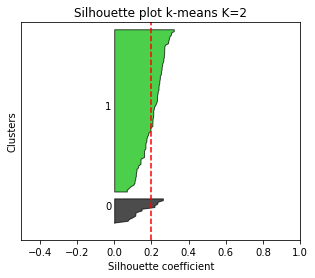

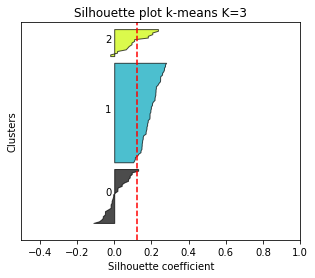

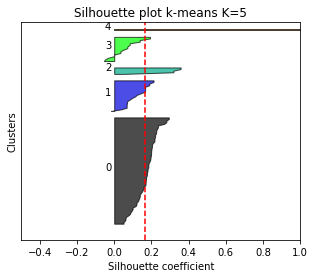

In [82]:
clusters = [2, 3, 5]
dataset = X_variance

for K in clusters:
    kms = KMeans(n_clusters = K, random_state=0).fit(dataset) 
    drawSillouette(dataset, kms.labels_, "k-means K=%d" %K)

### **HAC**

In [98]:
clusters = [2, 3, 5]
dataset = X_variance
linkage = "ward"
    
for K in clusters:
    hac_ward = AgglomerativeClustering(linkage = linkage, n_clusters = K).fit(dataset)
    print("Silhouette score for HAC with K=%d on X_variance dataset -->" %K, round(silhouette_score(dataset, hac_ward.labels_), 3))

Silhouette score for HAC with K=2 on X_variance dataset --> 0.166
Silhouette score for HAC with K=3 on X_variance dataset --> 0.175
Silhouette score for HAC with K=5 on X_variance dataset --> 0.097


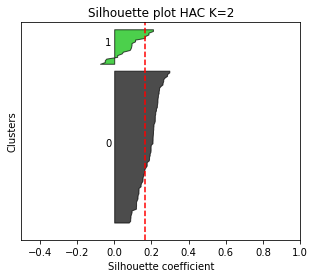

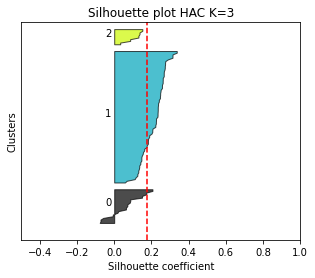

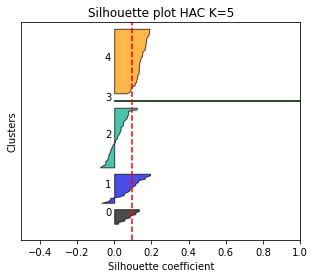

In [99]:
clusters = [2, 3, 5]
dataset = X_variance
linkage = "ward"

for K in clusters:
    hac_ward = AgglomerativeClustering(linkage = linkage, n_clusters = K).fit(dataset)
    drawSillouette(dataset, hac_ward.labels_, "HAC K=%d" %K)

### 5.1.1.2 **The Calinsky-Harabasz metric**

### **K-means**

In [90]:
clusters = [2, 3, 5]
dataset = X_variance

for K in clusters:
    kms = KMeans(n_clusters = K, random_state=0).fit(dataset)  
    print("Calinski Harabasz score for k-means with K=%d on X_variance dataset -->" % K, round(calinski_harabasz_score(dataset, kms.labels_), 3))

Calinski Harabasz score for k-means with K=2 on X_variance dataset --> 14.464
Calinski Harabasz score for k-means with K=3 on X_variance dataset --> 13.077
Calinski Harabasz score for k-means with K=5 on X_variance dataset --> 10.576


### **HAC**

In [100]:
clusters = [2, 3, 5]
dataset = X_variance
linkage = "ward"

for K in clusters:
    hac_ward = AgglomerativeClustering(linkage = linkage, n_clusters = K).fit(dataset)
    print("Calinski Harabasz score for HAC with K=%d on X_variance dataset -->" % K, round(calinski_harabasz_score(dataset, hac_ward.labels_), 3))

Calinski Harabasz score for HAC with K=2 on X_variance dataset --> 13.265
Calinski Harabasz score for HAC with K=3 on X_variance dataset --> 11.443
Calinski Harabasz score for HAC with K=5 on X_variance dataset --> 10.27


### 5.1.1.3 **Discussion**

- Looking at the quality scores for k-means and HAC, we could say that, across all values, the k-means clustering give the best clustering. 
- This interpretation has to be taken with some caution. K-means works by calculating centroids and building clusters from that. The Calinsky-Harabasz metric evaluates the distance of objects to centroids and, as such, k-means can show a higher score using this metric.
- For both k-means and HAC, the best clustering is obtained for k=2. Looking at the silhouette profile for this clustering shows that this is due to the fact that the majority of the objects of the dataset are attributed to a single cluster.

## 5.1.2 PCA dataset (23 components explaining 70% of the variance of the dataset)

### 5.1.2.1 **Silhouette Score**

### **K-means**

In [128]:
clusters = [2, 3, 5]
dataset = X_PCA

for K in clusters:
    kms = KMeans(n_clusters = K, random_state=0).fit(dataset)  
    print("Silhouette score for k-means with K=%d on X_PCA dataset -->" %K, round(silhouette_score(dataset, kms.labels_), 3))

Silhouette score for k-means with K=2 on X_PCA dataset --> 0.155
Silhouette score for k-means with K=3 on X_PCA dataset --> 0.172
Silhouette score for k-means with K=5 on X_PCA dataset --> 0.179


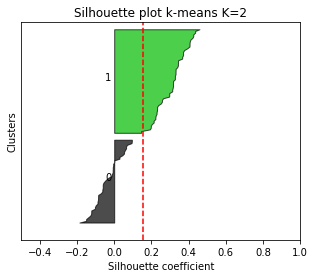

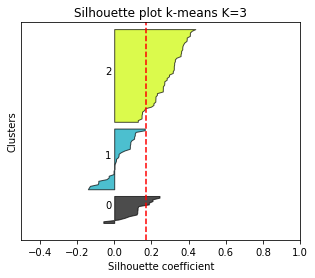

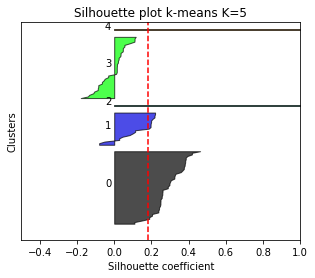

In [129]:
clusters = [2, 3, 5]
dataset = X_PCA

for K in clusters:
    kms = KMeans(n_clusters = K, random_state=0).fit(dataset) 
    drawSillouette(dataset, kms.labels_, "k-means K=%d" %K)

### **HAC**

In [130]:
clusters = [2, 3, 5]
dataset = X_PCA
linkage = "ward"
    
for K in clusters:
    hac_ward = AgglomerativeClustering(linkage = linkage, n_clusters = K).fit(dataset)
    print("Silhouette score for HAC with K=%d on X_PCA dataset -->" %K, round(silhouette_score(dataset, hac_ward.labels_), 3))

Silhouette score for HAC with K=2 on X_PCA dataset --> 0.233
Silhouette score for HAC with K=3 on X_PCA dataset --> 0.129
Silhouette score for HAC with K=5 on X_PCA dataset --> 0.154


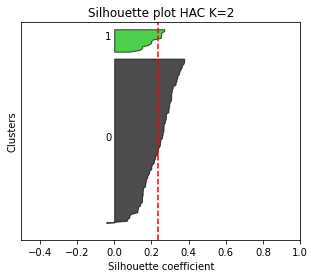

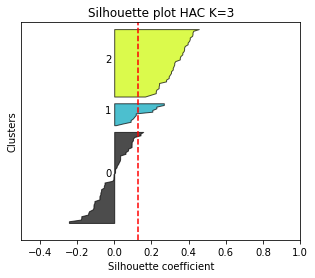

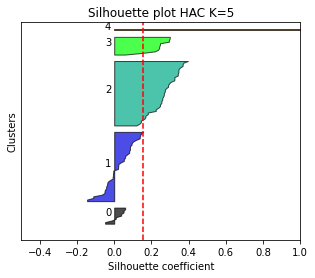

In [131]:
clusters = [2, 3, 5]
dataset = X_PCA
linkage = "ward"

for K in clusters:
    hac_ward = AgglomerativeClustering(linkage = linkage, n_clusters = K).fit(dataset)
    drawSillouette(dataset, hac_ward.labels_, "HAC K=%d" %K)

### 5.1.2.2 **The Calinsky-Harabasz metric**

### **K-means**

In [132]:
clusters = [2, 3, 5]
dataset = X_PCA

for K in clusters:
    kms = KMeans(n_clusters = K, random_state=0).fit(dataset)  
    print("Calinski Harabasz score for k-means with K=%d on X_PCA dataset -->" % K, round(calinski_harabasz_score(dataset, kms.labels_), 3))

Calinski Harabasz score for k-means with K=2 on X_PCA dataset --> 17.387
Calinski Harabasz score for k-means with K=3 on X_PCA dataset --> 17.991
Calinski Harabasz score for k-means with K=5 on X_PCA dataset --> 13.359


### **HAC**

In [133]:
clusters = [2, 3, 5]
dataset = X_PCA
linkage = "ward"

for K in clusters:
    hac_ward = AgglomerativeClustering(linkage = linkage, n_clusters = K).fit(dataset)
    print("Calinski Harabasz score for HAC with K=%d on X_PCA dataset -->" % K, round(calinski_harabasz_score(dataset, hac_ward.labels_), 3))

Calinski Harabasz score for HAC with K=2 on X_PCA dataset --> 15.713
Calinski Harabasz score for HAC with K=3 on X_PCA dataset --> 16.729
Calinski Harabasz score for HAC with K=5 on X_PCA dataset --> 13.866


### 5.1.2.3 **Discussion**

- Similarly to the X_variance clutering, the k-means clustering seems to give the best clustering. Again, we have to be careful when comparing the values of clustering using different clustering algorithms. 
- From the combined analysis of silhouette and Calinsky-Harabasz scores (specially the latter), a clustering with k=3 seems to have high scores.
- Looking at the silhouette profiles still shows many objects with negative silhouette scores, testifying to the difficulty of clustering the data and the irregular shape of the clusters formed.

## 5.1.3 Conclusion for metrics without ground truth

- The first striking obeservation, in our opinion, is that the X_PCA dataset seems to behave much better for the majority of the metrics and k values tested. 
- This makes total sense and, in our opinion, points towards a dubious approach in data processing and dimensionality reduction: eliminating certain features from a dataset, might lead to significant changes to the way the multimensional data of each object is distributed. Thus, using PCA dimensionality reduction should be the preferred strategy to deal with the question of multidimensionality.
- Another very interesting observation is that, clustering the data in 2 clusters (to match the ALL/AML label description) is clearly innapropriate. 
- If we focus on the quality measurements made for the clustering of the X_PCA data, we can clearly see that the highest value for k is 3.
- The dataset is difficult to cluster, likely because the captured difference between individuals is small, or there is too much noise in the data. As a result, we didn't manage to find well defined and distinct clusters in the data. 
- If we consider the biology of leukemia, it's actually rewarding to observe that we can find at least three distinct clusters of pacients. As mentioned in the introduction to this project, leukemia is a multifactorial, complex disease, with a diverse array of molecular and genetic fingerprints. If we believe that many diagnosed ALL and AML patients are poorly diagnosed (and do not consider that the patients might actually have a subtype of leukemia), we can easily understand how expecting a partitioning in two big clusters is too naive.
- The other issue that we have to keep in mind is that we are not making differential gene expression analysis for different groups of patients. We have to contemplate that the gene expression changes between ALL and AML patients are not that dramatic to allow a clear clustering of the data. With this in mind, it would have been interesting to have a third group of control individuals to improve the analysis of the data.
- We believe this is a great example of how knowing labels can influence the way that the data analysis is conducted. We tried to steer away from it as much as possible and decided we should let the data speak for itself (even if the data is in quite bad shape to speak well and eloquently).

## 5.2. Using Ground Truth

**Choose one adequate measure** from those available by Sciki-learn (https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) to evaluate the different clusterings. 

Discuss the results.

#### Given the knowledge of the ground truth class assignments of the samples, different metrics can be used to judge the quality of the clustering. One should keep in mind though, that these metrics are as appropriate as the adequate labelling of the classes on the dataset.
#### With this in mind, we will use the only measures introduced to us in the practical classes, the homogeneity, completeness and V-measure. 

### Let's remind ourselves of the "ground truth" or, in other words, the diagnosis attributed to each of the 110 pacients.

In [122]:
print("y Labels: ",set(y))
print("N. ALL cases: ",list(y).count('ALL'))
print("N. AML cases: ",list(y).count('AML'))

y Labels:  {'AML', 'ALL'}
N. ALL cases:  70
N. AML cases:  40


## 5.2.1 Homogeneity, completeness and V-measure
- When having knowledge about the ground truth, is is possible to define some intuitive metric using conditional entropy analysis. These intuitive metrics can be:
- **Homogeneity** - measures whether each cluster contains only members of a single class. Homogeneity score ranges between 0 and 1.
- **Completeness** - determines whether all members of a given class are assigned to the same cluster. Completeness score ranges between 0 and 1. It  has a big limitation when the number of clusters is very different from the number of labels, as it will always give very low scores, independently of how good the clustering is.
- **V-measure** - provides a composite score for both previous parameters, by calculating their harmonic mean.

### 5.2.1.1 Using the low-variance dataset

In [124]:
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score

cls = [2, 3, 5]
for value in cls:
    
    K = value
    dataset = X_variance

    kms, hac_ward = clusterAll(K, dataset)
    print("For K="+str(K))
    print("Kmeans homogeneity score", homogeneity_score(y, kms.labels_))
    print("Kmeans completeness score", completeness_score(y, kms.labels_))
    print("Kmeans V-measure score", v_measure_score(y, kms.labels_), "\n")
    print("HAC-ward homogeneity score", homogeneity_score(y, hac_ward.labels_))
    print("HAC-ward completeness score", completeness_score(y, hac_ward.labels_))
    print("HAC-ward V-measure score", v_measure_score(y, hac_ward.labels_), "\n")

For K=2
Kmeans homogeneity score 0.05699262420439139
Kmeans completeness score 0.09379100979615568
Kmeans V-measure score 0.07090153796191566 

HAC-ward homogeneity score 0.06603613797315512
HAC-ward completeness score 0.08878373127368508
HAC-ward V-measure score 0.07573878929987864 

For K=3
Kmeans homogeneity score 0.18393613046322319
Kmeans completeness score 0.12297851254877112
Kmeans V-measure score 0.14740379609362522 

HAC-ward homogeneity score 0.19606830598191316
HAC-ward completeness score 0.1665038091989601
HAC-ward V-measure score 0.18008069811375263 

For K=5
Kmeans homogeneity score 0.2721190246621884
Kmeans completeness score 0.1613152713082034
Kmeans V-measure score 0.20255413426953758 

HAC-ward homogeneity score 0.23085917974644088
HAC-ward completeness score 0.11384620239047147
HAC-ward V-measure score 0.15249219921186205 



### 5.2.1.2 Using the PCA dataset

In [125]:
from sklearn.metrics.cluster import v_measure_score

cls = [2, 3, 5]
for value in cls:
    
    K = value
    dataset = X_PCA

    kms, hac_ward = clusterAll(K, dataset)
    print("For K="+str(K))
    print("Kmeans homogeneity score", homogeneity_score(y, kms.labels_))
    print("Kmeans completeness score", completeness_score(y, kms.labels_))
    print("Kmeans V-measure score", v_measure_score(y, kms.labels_), "\n")
    print("HAC-ward homogeneity score", homogeneity_score(y, hac_ward.labels_))
    print("HAC-ward completeness score", completeness_score(y, hac_ward.labels_))
    print("HAC-ward V-measure score", v_measure_score(y, hac_ward.labels_), "\n")

For K=2
Kmeans homogeneity score 0.011145956626107444
Kmeans completeness score 0.010631740209447866
Kmeans V-measure score 0.010882777561773943 

HAC-ward homogeneity score 0.050704332596785036
HAC-ward completeness score 0.087194260386621
HAC-ward V-measure score 0.06412141971174316 

For K=3
Kmeans homogeneity score 0.24427279834072968
Kmeans completeness score 0.16031376305468764
Kmeans V-measure score 0.19358177087660824 

HAC-ward homogeneity score 0.09074304534543474
HAC-ward completeness score 0.06089412043387651
HAC-ward V-measure score 0.07288078622946047 

For K=5
Kmeans homogeneity score 0.24902076157578248
Kmeans completeness score 0.136698111687266
Kmeans V-measure score 0.1765050674879456 

HAC-ward homogeneity score 0.21448701762273326
HAC-ward completeness score 0.10990799693802852
HAC-ward V-measure score 0.1453403253317302 



### 5.2.1.3 Discussion

- The homogeneity, completeness and V-measure scores use the ground truth to provide metrics to analyse the clustering quality of an algorithm. The analysis of the obtained results is slightly different from that obtained with unsupervised metrics. 
- To start with, it is hard to distinguish which dataset gives the highest scores. The X_variance dataset seems to provide highest scores for k=2 and k=5, whereas the X_PCA dataset seems to provide highest scores for k=3.
- It's also more difficult to choose from a clustering algorithm but, as previously, this metric is not appropriate to compare different clustering algorithms (we will get to that in a second).
- If we are faithful to the arguments above, of not favoring the use of the X_variance dataset, the X_PCA clustering gives the highest v-measure score for k-means with k=3.

## 5.2.2 Adjusted Rand index
- Given the knowledge of the ground truth class assignments and the class assignment predicted by the clustering algorithm, the adjusted Rand index is a function that measures the similarity of the two assignments, ignoring permuations and with chance normalization.
- Gives values between -1 (independent labelling) or +1 (perfect match score).
- **As no assumption is made on the cluster structure, this metric can be used to compare different clustering algorithms.**

### 5.2.2.1 Using the low-variance dataset

In [126]:
from sklearn.metrics.cluster import adjusted_rand_score

cls = [2, 3, 5]
for value in cls:
    
    K = value
    dataset = X_variance

    kms, hac_ward = clusterAll(K, dataset)
    print("For K="+str(K))
    print("Kmeans Adjusted Rand score", adjusted_rand_score(y, kms.labels_))
    print("HAC-ward Adjusted Rand score", adjusted_rand_score(y, hac_ward.labels_), "\n")

For K=2
Kmeans Adjusted Rand score -0.043923309148287584
HAC-ward Adjusted Rand score -0.033475888133332785 

For K=3
Kmeans Adjusted Rand score 0.12312152279540113
HAC-ward Adjusted Rand score 0.06191080495651987 

For K=5
Kmeans Adjusted Rand score 0.1364424199007541
HAC-ward Adjusted Rand score 0.0705615099591292 



### 5.2.2.2 Using the PCA dataset

In [127]:
from sklearn.metrics.cluster import adjusted_rand_score

cls = [2, 3, 5]
for value in cls:
    
    K = value
    dataset = X_PCA

    kms, hac_ward = clusterAll(K, dataset)
    print("For K="+str(K))
    print("Kmeans Adjusted Rand score", adjusted_rand_score(y, kms.labels_))
    print("HAC-ward Adjusted Rand score", adjusted_rand_score(y, hac_ward.labels_), "\n")

For K=2
Kmeans Adjusted Rand score 0.011992215579360808
HAC-ward Adjusted Rand score -0.04412111188620593 

For K=3
Kmeans Adjusted Rand score 0.18406670493915311
HAC-ward Adjusted Rand score 0.013213709326405074 

For K=5
Kmeans Adjusted Rand score 0.1210876180298458
HAC-ward Adjusted Rand score 0.053280415074424436 



### 5.2.2.3 Discussion

This measure is great for our analysis in may ways:
- It first demonstrates that X_PCA seems more adequate to find the true partition of the data.
- As it can be used to compare different clustering algorithms, it also has the ability to show how superior k-means is for this exercise (well, let's not get too excited, and remind ourselves that this is measuring the quality of the clustering, using a ground truth prior-knowledge).
- If we focus on the X_PCA dataset, we can clearly see that the best results are obtained for k=3.
- The ARI score for clustering of the X_PCA dataset with k-means and k=3 is 0.1841. This is still far from perfect, showing that many clustering labels are independent from the ground truth labels.

## 5.2.3 Conclusion for metrics with ground truth

- The combined analysis of our supervised metrics reassures us about our choice of settling on the X_PCA dataset for further analysis.
- Using the ground truth, to measure clusters obtained with both k-means and HAC for k=2, clearly fails to measure a dependence between clustering and ground truth labels.
- In general, the results suggest that the best clustering for the data is achieved using k-means with k=3. This nicely matches our unsupervised clustering metrics and reinforce our confidence on the analysis.
- Thinking strictly in terms of diagnosis of the patients, we can't reproduce a clustering that can replicate the molecular clustering of ALL and AML patients perfectly. 
- This can be due to several reasons, like poor or biased clustering techniques used in the initial study (don't let the ground truth guide your science...), insuficient clustering that fails to consider the possibility patients suffer from subtypes of leukemia, insufficient quality of the data to allow a finer separation of the different patients (this might have been exacerbated by the duplication of patients that the teacher performed in the dataset).

### Bonus: The code below will run a random dataset (same dimension as the X_PCA) to make sure that our clustering measures and metrics are appropriate.
We hid it, as although confirming that our clustering is significative, this is just extra code that breaks the flow of this document!)

In [134]:
def showClusteringResults(X, clusters, labels=None):
    sil=silhouette_score(X, clusters)
    ch=calinski_harabasz_score(X, clusters)
    print("Silhouette_score", sil)
    print("Calinski Harabasz score", ch)
    if labels is not None:
        hom=homogeneity_score(clusters, labels)
        cmp=completeness_score(clusters, labels)
        vms=v_measure_score(clusters, labels)
        print("Homogeneity score", hom)    
        print("Completeness score", cmp)
        print("V-measure score", vms)
    

def getClusteringResults(X, clusters, labels=None):
    sil=silhouette_score(X, clusters)
    ch=calinski_harabasz_score(X, clusters)
    if labels is not None:
        hom=homogeneity_score(clusters, labels)
        cmp=completeness_score(clusters, labels)
        vms=v_measure_score(clusters, labels)
    else:
        hom, cmp, vms=None, None, None
    return sil, ch, hom, cmp, vms

In [135]:
showClusteringResults(X_PCA, kms.labels_, y)

Silhouette_score 0.17905771957819427
Calinski Harabasz score 13.359442296324769
Homogeneity score 0.13669811168726603
Completeness score 0.2490207615757825
V-measure score 0.17650506748794562


In [136]:
N=len(X_PCA)
rand_clust = np.random.randint(K, size=N)

showClusteringResults(X_PCA, rand_clust, y)

Silhouette_score -0.05039006131560025
Calinski Harabasz score 1.2275241590612922
Homogeneity score 0.03323918284176687
Completeness score 0.08031469140814705
V-measure score 0.047018998342938635


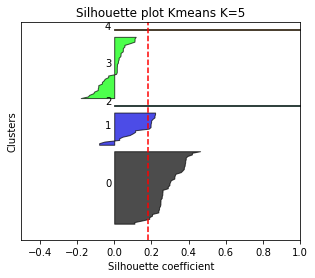

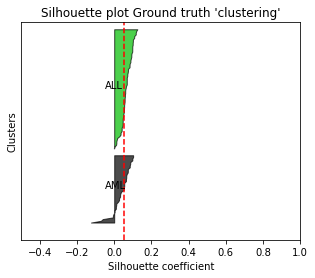

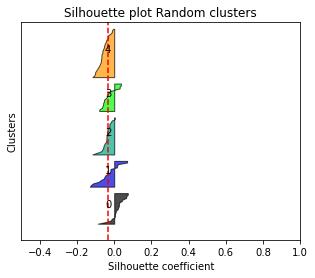

In [137]:
drawSillouette(X_PCA, kms.labels_, "Kmeans K=5")
drawSillouette(X, y, "Ground truth 'clustering'")
drawSillouette(X, rand_clust, "Random clusters")

## 6. Clustering Patients using Density-based Clustering

Use DBSCAN (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) or OPTICS (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html) to cluster the patients.

Compare the results with those of K-means and HCA.

- **Density-based clustering algorithms finds core samples (core points with a number of neighbours largen than a given number) among the data that have high density and expands clusters from them. Therefore, it requires two parameters: `eps` which corresponds to the maximal distance required so that a point can be considered a neighbour and `Nmin` which corresponds to the minimum number of neighbours that are required so that a certain point is considered a core point.**
- **The main ideia is based on the identification of the core points and clustering the connected components of core points in the neighborhood. It finally, assigns each non-core to the core point connected cluster if its distance if smaller than `eps`.**
- **The greatest advantage when compared to the HCA clustering is that it is faster and can deal with a huge amount of data. A particular characteristic about DBSCAN is that some points might not be clustered into a cluster and, therefore, can be identified as noise.**
- **Considerind that our data has a high number of features (high dimensional data) with low number of individuals (110) it is expected that DBSCAN doesn't work with a great performance when compared with the other clustering algorithms.**

Let's start by creating a formula to calculate the average distance between all points.

In [153]:
from scipy.spatial.distance import pdist, squareform

def mean_distance(db):
    """
    Calculating the mean distance between points.
    Requires: db as a data matrix.
    """
    D=pdist(db, metric="euclidean")
    meanD = sum(D)/len(D)
    return D, meanD

In [154]:
matrix_D, mean_distance = mean_distance(X)

In [155]:
#distance matrix of X objects
dists=squareform(matrix_D, checks=True)

#print(dists[1]) (IDs an object that is duplicated, has two objects with 0 distance)
for d in dists[:4]:
    print(d[:4])

[ 0.         90.90874432 91.5064269  77.24229507]
[ 90.90874432   0.         100.10166853  88.88452846]
[ 91.5064269  100.10166853   0.          95.53045954]
[77.24229507 88.88452846 95.53045954  0.        ]


##### Computing the average distance between all objects in X

In [156]:
eps = mean_distance/2 #calculating eps value 
print('Average distance: ', mean_distance)

Average distance:  98.52006037848903


In [157]:
from sklearn.preprocessing import StandardScaler

def dbscan_clust (db, eps, Nmin):
    """
    Clustering data using DBSCAN algorithm from scikit learn.
    Requires: db as a matrix with each line as a patient; eps and Nmin as int.
    Ensures: an array with the clusters and their elements.
    """
    data = StandardScaler().fit_transform(db)
    
    cluster = DBSCAN(eps=eps, min_samples = Nmin).fit(data)
    
    l = cluster.labels_
    
    core_samples_mask = np.zeros_like(l, dtype=bool)
    core_samples_mask[cluster.core_sample_indices_] = True
    
    n_clusters = len(set(l)) - (1 if -1 in l else 0)
    n_noise = list(l).count(-1)
    
    return l, n_clusters, n_noise

In [158]:
from sklearn import metrics

def dbscan_metrics(y, labels):
    """
    Calculating metrics values for DBSCAN clustering evaluation.
    """
    
    print("Homogeneity score: %0.3f" % metrics.homogeneity_score(y, labels))
    
    print("Completeness score: %0.3f" % metrics.completeness_score(y, labels))
    
    print("V-measure score: %0.3f" % metrics.v_measure_score(y, labels))
    
    print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y, labels))
    
    print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y, labels, average_method='arithmetic'))

#### DBSCAN with `eps`=mean_distance/2 of X and `Nmin`=1 

In [159]:
X_dbscan, n_clusters, n_noise = dbscan_clust(X, eps, 1)

print(getLabelsClustering(n_clusters, X_dbscan, y), '\n')

print('Number of clusters: ', n_clusters)

#points that were not assigned to any cluster.
print('Number of noise points: ', n_noise)

dbscan_metrics(y, X_dbscan)

{0: {'ALL': 1}, 1: {'ALL': 2}, 2: {'ALL': 1}, 3: {'ALL': 2, 'AML': 1}, 4: {'ALL': 1, 'AML': 1}, 5: {'ALL': 2}, 6: {'ALL': 1}, 7: {'ALL': 2}, 8: {'ALL': 1}, 9: {'ALL': 2}, 10: {'ALL': 1}, 11: {'ALL': 2}, 12: {'ALL': 1}, 13: {'ALL': 2}, 14: {'ALL': 1}, 15: {'ALL': 2}, 16: {'ALL': 1}, 17: {'ALL': 2}, 18: {'ALL': 1}, 19: {'ALL': 2}, 20: {'ALL': 1}, 21: {'ALL': 2}, 22: {'ALL': 1}, 23: {'ALL': 2}, 24: {'ALL': 1}, 25: {'ALL': 2}, 26: {'ALL': 1}, 27: {'ALL': 2}, 28: {'ALL': 1}, 29: {'ALL': 2}, 30: {'ALL': 1}, 31: {'ALL': 2}, 32: {'ALL': 1}, 33: {'ALL': 2}, 34: {'ALL': 1}, 35: {'ALL': 2}, 36: {'ALL': 1}, 37: {'ALL': 2}, 38: {'ALL': 1}, 39: {'ALL': 2}, 40: {'ALL': 1}, 41: {'ALL': 2}, 42: {'ALL': 1}, 43: {'ALL': 2}, 44: {'ALL': 1}, 45: {'ALL': 2}, 46: {'ALL': 1}, 47: {'AML': 2}, 48: {'AML': 1}, 49: {'AML': 2}, 50: {'AML': 1}, 51: {'AML': 2}, 52: {'AML': 1}, 53: {'AML': 2}, 54: {'AML': 1}, 55: {'AML': 2}, 56: {'AML': 1}, 57: {'AML': 2}, 58: {'AML': 1}, 59: {'AML': 2}, 60: {'AML': 1}, 61: {'AML': 2

#### DBSCAN with `eps`=mean_distance of X and `Nmin`=1 

In [160]:
X_dbscan, n_clusters, n_noise = dbscan_clust(X, mean_distance, 1)

print(getLabelsClustering(n_clusters, X_dbscan, y), '\n')

print('Number of clusters: ', n_clusters)

#points that were not assigned to any cluster.
print('Number of noise points: ', n_noise) 

dbscan_metrics(y, X_dbscan)

{0: {'ALL': 67, 'AML': 39}, 1: {'ALL': 1}, 2: {'ALL': 2}, 3: {'AML': 1}} 

Number of clusters:  4
Number of noise points:  0
Homogeneity score: 0.033
Completeness score: 0.111
V-measure score: 0.051
Adjusted Rand Index: -0.009
Adjusted Mutual Information: 0.008


#### DBSCAN with `eps`=mean_distance/2 of X and `Nmin`=2

In [161]:
X_dbscan, n_clusters, n_noise = dbscan_clust(X, eps, 2)

print(getLabelsClustering(n_clusters, X_dbscan, y), '\n')

print('Number of clusters: ', n_clusters)

#points that were not assigned to any cluster.
print('Number of noise points: ', n_noise)

dbscan_metrics(y, X_dbscan)

{0: {'ALL': 2}, 1: {'ALL': 2, 'AML': 1}, 2: {'ALL': 1, 'AML': 1}, 3: {'ALL': 2}, 4: {'ALL': 2}, 5: {'ALL': 2}, 6: {'ALL': 2}, 7: {'ALL': 2}, 8: {'ALL': 2}, 9: {'ALL': 2}, 10: {'ALL': 2}, 11: {'ALL': 2}, 12: {'ALL': 2}, 13: {'ALL': 2}, 14: {'ALL': 2}, 15: {'ALL': 2}, 16: {'ALL': 2}, 17: {'ALL': 2}, 18: {'ALL': 2}, 19: {'ALL': 2}, 20: {'ALL': 2}, 21: {'ALL': 2}, 22: {'ALL': 2}, 23: {'ALL': 2}, 24: {'AML': 2}, 25: {'AML': 2}, 26: {'AML': 2}, 27: {'AML': 2}, 28: {'AML': 2}, 29: {'AML': 2}, 30: {'AML': 2}, 31: {'AML': 2}, 32: {'AML': 2}, 33: {'AML': 2}, 34: {'AML': 2}, 35: {'AML': 2}, 36: {'AML': 2}} 

Number of clusters:  37
Number of noise points:  35
Homogeneity score: 0.642
Completeness score: 0.136
V-measure score: 0.225
Adjusted Rand Index: 0.011
Adjusted Mutual Information: 0.119


#### DBSCAN with `eps`=mean_distance of X and `Nmin`=2

In [162]:
X_dbscan, n_clusters, n_noise = dbscan_clust(X, mean_distance, 2)

print(getLabelsClustering(n_clusters, X_dbscan, y), '\n')

print('Number of clusters: ', n_clusters)

#points that were not assigned to any cluster.
print('Number of noise points: ', n_noise) 

dbscan_metrics(y, X_dbscan)

{0: {'ALL': 67, 'AML': 39}, 1: {'ALL': 2}} 

Number of clusters:  2
Number of noise points:  2
Homogeneity score: 0.014
Completeness score: 0.049
V-measure score: 0.021
Adjusted Rand Index: -0.010
Adjusted Mutual Information: -0.008


#### DBSCAN with `eps`=mean_distance/2 and `Nmin`=3

In [163]:
X_dbscan, n_clusters, n_noise = dbscan_clust(X, eps, 3)

print(getLabelsClustering(n_clusters, X_dbscan, y),'\n')

print('Number of clusters: ', n_clusters)

#points that were not assigned to any cluster.
print('Number of noise points: ', n_noise)

dbscan_metrics(y, X_dbscan)

{0: {'ALL': 2, 'AML': 1}} 

Number of clusters:  1
Number of noise points:  107
Homogeneity score: 0.000
Completeness score: 0.000
V-measure score: 0.000
Adjusted Rand Index: -0.003
Adjusted Mutual Information: -0.015


#### DBSCAN with `eps`=mean_distance and `Nmin`=3

In [165]:
X_dbscan, n_clusters, n_noise = dbscan_clust(X, mean_distance, 3)

print(getLabelsClustering(n_clusters, X_dbscan, y))

print('Number of clusters: ', n_clusters)

#points that were not assigned to any cluster.
print('Number of noise points: ', n_noise)

dbscan_metrics(y, X_dbscan)

{0: {'ALL': 67, 'AML': 39}}
Number of clusters:  1
Number of noise points:  4
Homogeneity score: 0.002
Completeness score: 0.007
V-measure score: 0.003
Adjusted Rand Index: -0.010
Adjusted Mutual Information: -0.011


# The evaluation of clustering with DBSCAN is done using a certain set of metrics:

- **Homogeneity** which informs us if all of its clusters contain only data points which are members of a single class (AML or ALL). Therefore, high values of homogeneity score reprents clusters that are homogeneous.
- **Completeness** which informs us if all the data points that are members of a given class are elements of the same cluster (if all de ALL patients were clustered in the same cluster and if all AML patients were clusteres in the same cluster).
- **V-measure** is an harmonic mean between homogeneity and completeness.
- **Adjusted Mutual Information** which is an adjustment of the Mutual Information (MI) score to account for chance. It accounts for the fact that the MI is generally higher for two clusterings with a larger number of clusters, regardless of whether there is actually more information shared.
- **Adjusted Rand Index** which is a measure that computes the similarity between two clusters by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

### Therefore,

- The measurements of the **homogeneity** scores reveal very low values for any value of `eps` (mean(X) and mean(X)/2) and` Nmin` (Nmin=1 or Nmin=3). This means that there is no result of clustering with the DBSCAN algorithm that allows building clusters with a single type of diagnosis (AML or ALL) or, for high values of homogeneity score but different from 1, clusters that present an equally diagnosed majority. Only in the case in which 72 clusters  were determined, a high homogeneity score was observed (eps=mean(X) and Nmin=1). This would be expected considering the high number of clusters, each clusters presents, as a general rule, one element per cluster. Thus, it is normal to have a large number of homogeneous clusters.

- The measurements of the **completeness** scores also reveal low values for any value of `eps` and` Nmin` (the highest value being 0.148 for Nmin=1 and eps=mean(X)). This means that hardly any clusters will be found that bring together all, or a majority of patients with a certain diagnosis (all ALL patients or all AML patients).

- On the same note, the **V-measure** score translates the same ideia that was observed considering the homogeneity and completeness matrics: that hardly any cluster obtained with DBSCAN algorithm can collect a high and majority number of patients with the same diagnosis. Like the previous metrics, the V-measure score is also low for all the values of `eps`and `Nmin`. 

- For ideal clustering, the **Adjusted Rand Index** should approach 1. Considering the values obtained under the conditions tested, we observe that these values are very close, if not equal, to 0. This corroborates the idea obtained with the previous metrics that the DBSCAN is not the most suitable algorithm for clustering this data.



# 7 General conclusion
The results and conclusions obtained in this exercise do not meet our initial expectations. None of our many clustering efforts provided us with a clear clustering of the patients. Moreover, our efforts failled to attribute an accurate clustering to the ground truth information we had, about patients diagnosis. 
This exercise also shows us that data, more than "knowledge", should lead our research. Data is data, whereas knowledge might be biased and/or wrong. 
In this case, there are several problems that might have biased the initial study:
- Diagnosis of ALL and AML patients might have been oversimplistic, not considering subtypes of leukima.
- Following a previous label to analyse the data, might have led the researched to obtain the results they wanted, and not the "real" results.
- Gene expression differences between ALL and AML might be too small to allow an efficient clustering of these distinct group of patients.
On top of this, we have to consider that microarray technology might not be sensitive enough to capture the differences between ALL and AML patients (and potential leukemia subtypes). Certainly, the data that was provided is not of the highest quality, which might also hinder our efforts.

Considering all of the above, we conclude that whereas being a difficult exercise and not allowing to perform a cohesive and clear clustering of patients, this was an interesting and rewarding project.